## Data Preprocessing

In [1]:
import os

import requests
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# xkcd-styled & humor sans font installed to give semi-sarcasm graph
plt.xkcd()
%matplotlib inline

### Constants and Helper Functions

In [2]:
# consts
TUNGUZ_DATASET_REPO_URL = 'https://raw.githubusercontent.com/tunguz/TabularBenchmarks/main/datasets/credit-g/input/'
ARFF_DATASET = 'dataset_31_credit-g.arff'
RANDOM_SEED = 42
TEST_SIZE = .3

In [3]:
def plot_bar(s: pd.Series):
    '''Plot labels bar purpose only'''
    label_counts = s.value_counts()

    plt.figure(figsize=(8, 6))
    bars = plt.bar(label_counts.index, label_counts.values)
    plt.xlabel('Label Class')
    plt.ylabel('Count')
    plt.title('Bar Plot of Labels')

    # Adding the counts above the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + .1, yval, ha='center', va='bottom')

    plt.show()

def plot_histogram(s: pd.Series):
    '''Plot features histogram purpose only'''
    plt.figure(figsize=(10, 8))
    plt.hist(s, bins='sqrt', edgecolor='black')

    mean = s.mean()
    median = s.median()
    mode = s.mode().values[0]  # Just take the first mode if there are multiple
    y_min, y_max = plt.gca().get_ylim()

    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
    plt.axvline(median, color='blue', linestyle='dashed', linewidth=2)
    plt.axvline(mode, color='green', linestyle='dashed', linewidth=2)
    plt.legend({'Mean':mean,'Median':median, 'Mode':mode})

    # Add text for mean, median and mode
    y_range = y_max - y_min
    y_text = [
        .25 * y_range + y_min,
        .5 * y_range + y_min,
        .75 * y_range + y_min,
    ]
    plt.text(mean, y_text[0], f'Mean: {mean:.2f}', color='red')
    plt.text(median, y_text[1], f'Median: {median:.2f}', color='blue')
    plt.text(mode, y_text[2], f'Mode: {mode:.2f}', color='green')

    plt.title(f'Histogram of {s.name}')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.show()

def plot_histogram_comparison(s1: pd.Series, s2: pd.Series):
    '''Plot 2 features histogram side by side for comparison purpose only'''
    _, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    for s, ax in zip((s1, s2), axes):
        ax.hist(s, bins='sqrt', edgecolor='black')

        mean = s.mean()
        median = s.median()
        mode = s.mode().values[0]  # Just take the first mode if there are multiple
        y_min, y_max = ax.get_ylim()

        ax.axvline(mean, color='red', linestyle='dashed', linewidth=2)
        ax.axvline(median, color='blue', linestyle='dashed', linewidth=2)
        ax.axvline(mode, color='green', linestyle='dashed', linewidth=2)
        ax.legend({'Mean':mean,'Median':median, 'Mode':mode})

        # Add text for mean, median and mode
        y_range = y_max - y_min
        y_text = [
            .25 * y_range + y_min,
            .5 * y_range + y_min,
            .75 * y_range + y_min,
        ]
        ax.text(mean, y_text[0], f'Mean: {mean:.2f}', color='red')
        ax.text(median, y_text[1], f'Median: {median:.2f}', color='blue')
        ax.text(mode, y_text[2], f'Mode: {mode:.2f}', color='green')

        ax.set_title(f'Histogram of {s.name}')
        ax.set_xlabel('Values')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

def check_missing_df(df: pd.DataFrame):
    '''Check missing data on features only'''
    total_values = df.size
    if df.isnull().any().any():
        print("There are missing values in the dataframe.")
        if df.isnull().any().sum() > 0:
            print("\nColumns with missing values:")
            print(df.isnull().sum()[df.isnull().sum() > 0])
        total_missing = df.isnull().sum().sum()
        print("\nTotal number of missing values: ", total_missing)
        print(f"Ratio of missing values: {total_missing}/{total_values} = {total_missing / total_values:.2}")
        print(f"Percentage of missing values = {total_missing / total_values:.2%}")
    else:
        print("There are no missing values in the dataframe.")

def check_missing_s(s: pd.Series):
    '''Check missing data on labels only'''
    total_values = s.size
    if s.isnull().any():
        print("There are missing values in the series.")
        total_missing = s.isnull().sum()
        print("Total number of missing values: ", total_missing)
        print(f"Ratio of missing values: {total_missing}/{total_values} = {total_missing / total_values:.2}")
        print(f"Percentage of missing values = {total_missing / total_values:.2%}")
    else:
        print("There are no missing values in the series.")

def check_duplicates_df(df: pd.DataFrame):
    '''Check duplicate data on DataFrame'''
    total_rows = df.shape[0]
    if df.duplicated().any():
        print("There are duplicated rows in the dataframe.")
        total_duplicates = df.duplicated().sum()
        print(f"\nTotal number of duplicated rows: {total_duplicates}")
        print(f"Ratio of duplicated rows: {total_duplicates}/{total_rows} = {total_duplicates / total_rows:.2}")
        print(f"Percentage of duplicated rows = {total_duplicates / total_rows:.2%}")

        # Print duplicated rows (showing first few rows)
        duplicated_rows = df[df.duplicated()]
        print("\nPreview of duplicated rows:")
        print(duplicated_rows)
    else:
        print("There are no duplicated rows in the dataframe.")


### Preprocessing

In [4]:
# loading the arrf dataset
url = f'{TUNGUZ_DATASET_REPO_URL}{ARFF_DATASET}'

if os.path.exists(ARFF_DATASET):
    with open(ARFF_DATASET, 'rt') as f:
        data, meta = arff.loadarff(f)
else:
    response = requests.get(url)
    if response.status_code == 200:
        with open(ARFF_DATASET, 'wb') as f:
            f.write(response.content)
        # Reopen the file in text mode for reading with arff.loadarff
        with open(ARFF_DATASET, 'rt') as f:
            data, meta = arff.loadarff(f)
    else:
        print(f"Couldn't download the file: {url}")

In [5]:
# take a peak at the first 5 data
data[:5]

array([(b'<0',  6., b'critical/other existing credit', b'radio/tv', 1169., b'no known savings', b'>=7', 4., b'male single', b'none', 4., b'real estate', 67., b'none', b'own', 2., b'skilled', 1., b'yes', b'yes', b'good'),
       (b'0<=X<200', 48., b'existing paid', b'radio/tv', 5951., b'<100', b'1<=X<4', 2., b'female div/dep/mar', b'none', 2., b'real estate', 22., b'none', b'own', 1., b'skilled', 1., b'none', b'yes', b'bad'),
       (b'no checking', 12., b'critical/other existing credit', b'education', 2096., b'<100', b'4<=X<7', 2., b'male single', b'none', 3., b'real estate', 49., b'none', b'own', 1., b'unskilled resident', 2., b'none', b'yes', b'good'),
       (b'<0', 42., b'existing paid', b'furniture/equipment', 7882., b'<100', b'4<=X<7', 2., b'male single', b'guarantor', 4., b'life insurance', 45., b'none', b'for free', 1., b'skilled', 2., b'none', b'yes', b'good'),
       (b'<0', 24., b'delayed previously', b'new car', 4870., b'<100', b'1<=X<4', 3., b'male single', b'none', 4., b'

In [6]:
# check the attribute meta to learn the context
meta

Dataset: german_credit
	checking_status's type is nominal, range is ('<0', '0<=X<200', '>=200', 'no checking')
	duration's type is numeric
	credit_history's type is nominal, range is ('no credits/all paid', 'all paid', 'existing paid', 'delayed previously', 'critical/other existing credit')
	purpose's type is nominal, range is ('new car', 'used car', 'furniture/equipment', 'radio/tv', 'domestic appliance', 'repairs', 'education', 'vacation', 'retraining', 'business', 'other')
	credit_amount's type is numeric
	savings_status's type is nominal, range is ('<100', '100<=X<500', '500<=X<1000', '>=1000', 'no known savings')
	employment's type is nominal, range is ('unemployed', '<1', '1<=X<4', '4<=X<7', '>=7')
	installment_commitment's type is numeric
	personal_status's type is nominal, range is ('male div/sep', 'female div/dep/mar', 'male single', 'male mar/wid', 'female single')
	other_parties's type is nominal, range is ('none', 'co applicant', 'guarantor')
	residence_since's type is nume

In [7]:
df = pd.DataFrame(data)
df.head()

checking_status  duration                     credit_history   
0           b'<0'       6.0  b'critical/other existing credit'  \
1     b'0<=X<200'      48.0                   b'existing paid'   
2  b'no checking'      12.0  b'critical/other existing credit'   
3           b'<0'      42.0                   b'existing paid'   
4           b'<0'      24.0              b'delayed previously'   

                  purpose  credit_amount       savings_status employment   
0             b'radio/tv'         1169.0  b'no known savings'     b'>=7'  \
1             b'radio/tv'         5951.0              b'<100'  b'1<=X<4'   
2            b'education'         2096.0              b'<100'  b'4<=X<7'   
3  b'furniture/equipment'         7882.0              b'<100'  b'4<=X<7'   
4              b'new car'         4870.0              b'<100'  b'1<=X<4'   

   installment_commitment        personal_status other_parties  ...   
0                     4.0         b'male single'       b'none'  ...  \
1                     2.0  b'female div/dep/mar'       b'none'  ...   
2                     2.0         b'male single'       b'none'  ...   
3                     2.0         b'male single'  b'guarantor'  ...   
4                     3.0         b'male single'       b'none'  ...   

     property_magnitude   age  other_payment_plans      housing   
0        b'real estate'  67.0              b'none'       b'own'  \
1        b'real estate'  22.0              b'none'       b'own'   
2        b'real estate'  49.0              b'none'       b'own'   
3     b'life insurance'  45.0              b'none'  b'for free'   
4  b'no known property'  53.0              b'none'  b'for free'   

  existing_credits                    job num_dependents  own_telephone   
0              2.0             b'skilled'            1.0         b'yes'  \
1              1.0             b'skilled'            1.0        b'none'   
2              1.0  b'unskilled resident'            2.0        b'none'   
3              1.0             b'skilled'            2.0        b'none'   
4              2.0             b'skilled'            2.0        b'none'   

  foreign_worker    class  
0         b'yes'  b'good'  
1         b'yes'   b'bad'  
2         b'yes'  b'good'  
3         b'yes'  b'good'  
4         b'yes'   b'bad'  

[5 rows x 21 columns]

In [8]:
# take a deep look into the data
for col in df.columns:
    if len(df[col].unique()) <= 10:
        print(df[col].unique())
        print(f'{col} - dtype: {df[col].dtype}', end='\n\n')
    else:
        print(df[col].describe(), end='\n\n')

[b'<0' b'0<=X<200' b'no checking' b'>=200']
checking_status - dtype: object

count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: duration, dtype: float64

[b'critical/other existing credit' b'existing paid' b'delayed previously'
 b'no credits/all paid' b'all paid']
credit_history - dtype: object

[b'radio/tv' b'education' b'furniture/equipment' b'new car' b'used car'
 b'business' b'domestic appliance' b'repairs' b'other' b'retraining']
purpose - dtype: object

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: credit_amount, dtype: float64

[b'no known savings' b'<100' b'500<=X<1000' b'>=1000' b'100<=X<500']
savings_status - dtype: object

[b'>=7' b'1<=X<4' b'4<=X<7' b'unemployed' b'<1']
employment - dtype: object

[4. 2. 3. 1.]
installm

### Attributte Description

From the previous cells we can tell the attributes:

| no | attribute | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | `checking_status` | ['<0', '0<=X<200', 'no checking', '>=200'] |  Status of existing checking account. **People with lower balances might be seen as higher risk.** | ✔ | there are order | - |
| 2 | `duration` | [4, 72] **inclusive range not unique values** | Duration in month. **Longer loan durations might be riskier as they offer more opportunities for the borrower's circumstances to change.** | - | long or short | ✔ |
| 3 | `credit_history` | ['critical/other existing credit', 'existing paid', 'delayed previously', 'no credits/all paid', 'all paid'] | The applicant’s track record in terms of past loans. **A history of delinquency could point to higher risk.** | ✔ | - | - |
| 4 | `purpose` | ['radio/tv', 'education', 'furniture/equipment', 'new car', 'used car', 'business', 'domestic appliance', 'repairs', 'other', 'retraining'] | Purpose for the loan. **Certain loan purposes might be associated with higher risk than others (e.g., starting a new business might be riskier than buying a car).** | ✔ | - | - |
| 5 | `credit_amount` | [250, 18424] **inclusive range not unique values** | The amount of loan in question. **Larger loans might be considered higher risk.** | - | small or big | ✔ |
| 6 | `savings_status` | ['no known savings', '<100', '500<=X<1000', '>=1000', '100<=X<500'] | Savings account/bonds. **Those with more savings might be considered lower risk.** | ✔ | there are order | - |
| 7 | `employment` | ['>=7', '1<=X<4', '4<=X<7', 'unemployed', '<1'] | Present employment since. **Longer employment might be seen as indicating more stable income.** | ✔ | there are order | - |
| 8 | `installment_commitment` | [1, 2, 3, 4] | Installment rate in percentage of disposable income. **Higher percentages could indicate financial strain and higher risk.** | - | low or high | ✔ |
| 9 | `personal_status` | ['male single', 'female div/dep/mar', 'male div/sep', 'male mar/wid'] | Personal status and sex includes marital status and gender. **These factors could have complex interactions with risk.** | ✔ | - | - |
| 10 | `other_parties` | ['none', 'guarantor', 'co applicant'] | Other debtors / guarantors that indicates if there are other people who share the responsibility of the loan. **Guarantors can decrease the risk.** | ✔ | - | - |
| 11 | `residence_since` | [1, 2, 3, 4] | How long the applicant has lived at their current address. **Longer times could indicate more stability.** | - | long or short | ✔ |
| 12 | `property_magnitude` | ['real estate', 'life insurance', 'no known property', 'car'] | Describes the types of property the person owns. **Describes the types of property the person owns.** | ✔ | - | - |
| 13 | `age` | [19, 75] **inclusive range not unique values** | The applicant’s age. **Risk can vary with age due to factors like income stability, health status, etc.** | - | older or younger | ✔ |
| 14 | `other_payment_plans` | ['none', 'bank', 'stores'] | Other installment plans that indicates if the borrower has other ongoing loans. **Additional financial obligations can increase risk.** | ✔ | - | - |
| 15 | `housing` | ['own', 'for free', 'rent'] | The type of housing the applicant lives in. **Those who own their homes might be seen as more stable/less risky.** | ✔ | - | - |
| 16 | `existing_credits` | [1, 2, 3, 4] | Number of existing credits at this bank. **Multiple loans could indicate higher risk.** | - | few or many | ✔ |
| 17 | `job` | ['skilled', 'unskilled resident', 'high qualif/self emp/mgmt', 'unemp/unskilled non res'] | The applicant's job status and type. **Certain jobs might be seen as more stable/less risky.** | ✔ | - | - |
| 18 | `num_dependents` | [1, 2] | Number of people being liable to provide maintenance for. **The more dependents person has, the more of their income is likely already spoken for, which can make it riskier for the bank to lend them money.** | - | - | ✔ |
| 19 | `own_telephone` | ['yes', 'none'] | Indicates if the applicant has a telephone registered under their name. **This could be seen as a sign of stability.** | ✔ | - | - |
| 20 | `foreign_worker` | ['yes', 'no'] | Indicates if the applicant is a foreign worker. **Foreign workers might be seen as higher risk due to potential job and legal uncertainties.** | ✔ | - | - |
| **no** | **attribute** | **unique_values** | **description** | **nominal** | **ordinal** | **ratio** |

And the label:

| no | label | unique_values | description | nominal | ordinal | ratio |
| --- | --- | --- | --- | --- | --- | --- |
| 1 | `class` | ['good', 'bad'] | Label that indicates whether the applicant is good or bad for the credit. | ✔ | - | - |

**NB:**

- There is no any nominal column that comes in a pure numeric form, so it is safe for encoding later
- Ordinal attributes could be made out from either nominal or ratio attributes, but for now we just stick with the original nominal and ratio attributes
- Because of the previous statement, there are a lot combination set of features to try on to get the optimal features for predictive model to train to
- Notice `personal_status`, which is a composite feature that includes both `gender` and `marital status`. In our current approach, these features are combined into a single attribute. However, it is possible that separating these features might provide different insights and potentially improve model performance.

In [9]:
# convert the byte string into regular string and numeric into their best data type
df = df.convert_dtypes()
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.decode('utf-8')
df.dtypes

checking_status           object
duration                   Int64
credit_history            object
purpose                   object
credit_amount              Int64
savings_status            object
employment                object
installment_commitment     Int64
personal_status           object
other_parties             object
residence_since            Int64
property_magnitude        object
age                        Int64
other_payment_plans       object
housing                   object
existing_credits           Int64
job                       object
num_dependents             Int64
own_telephone             object
foreign_worker            object
class                     object
dtype: object

In [10]:
df

checking_status  duration                  credit_history   
0                <0         6  critical/other existing credit  \
1          0<=X<200        48                   existing paid   
2       no checking        12  critical/other existing credit   
3                <0        42                   existing paid   
4                <0        24              delayed previously   
..              ...       ...                             ...   
995     no checking        12                   existing paid   
996              <0        30                   existing paid   
997     no checking        12                   existing paid   
998              <0        45                   existing paid   
999        0<=X<200        45  critical/other existing credit   

                 purpose  credit_amount    savings_status  employment   
0               radio/tv           1169  no known savings         >=7  \
1               radio/tv           5951              <100      1<=X<4   
2              education           2096              <100      4<=X<7   
3    furniture/equipment           7882              <100      4<=X<7   
4                new car           4870              <100      1<=X<4   
..                   ...            ...               ...         ...   
995  furniture/equipment           1736              <100      4<=X<7   
996             used car           3857              <100      1<=X<4   
997             radio/tv            804              <100         >=7   
998             radio/tv           1845              <100      1<=X<4   
999             used car           4576        100<=X<500  unemployed   

     installment_commitment     personal_status other_parties  ...   
0                         4         male single          none  ...  \
1                         2  female div/dep/mar          none  ...   
2                         2         male single          none  ...   
3                         2         male single     guarantor  ...   
4                         3         male single          none  ...   
..                      ...                 ...           ...  ...   
995                       3  female div/dep/mar          none  ...   
996                       4        male div/sep          none  ...   
997                       4         male single          none  ...   
998                       4         male single          none  ...   
999                       3         male single          none  ...   

     property_magnitude age  other_payment_plans   housing existing_credits   
0           real estate  67                 none       own                2  \
1           real estate  22                 none       own                1   
2           real estate  49                 none       own                1   
3        life insurance  45                 none  for free                1   
4     no known property  53                 none  for free                2   
..                  ...  ..                  ...       ...              ...   
995         real estate  31                 none       own                1   
996      life insurance  40                 none       own                1   
997                 car  38                 none       own                1   
998   no known property  23                 none  for free                1   
999                 car  27                 none       own                1   

                           job num_dependents  own_telephone foreign_worker   
0                      skilled              1            yes            yes  \
1                      skilled              1           none            yes   
2           unskilled resident              2           none            yes   
3                      skilled              2           none            yes   
4                      skilled              2           none            yes   
..                         ...            ...            ...            ...   
995

### Splitting the Dataset

In [11]:
# separating the features from the labels
features = df.drop('class', axis=1)
labels = df['class']

display(features)
display(labels)

checking_status  duration                  credit_history   
0                <0         6  critical/other existing credit  \
1          0<=X<200        48                   existing paid   
2       no checking        12  critical/other existing credit   
3                <0        42                   existing paid   
4                <0        24              delayed previously   
..              ...       ...                             ...   
995     no checking        12                   existing paid   
996              <0        30                   existing paid   
997     no checking        12                   existing paid   
998              <0        45                   existing paid   
999        0<=X<200        45  critical/other existing credit   

                 purpose  credit_amount    savings_status  employment   
0               radio/tv           1169  no known savings         >=7  \
1               radio/tv           5951              <100      1<=X<4   
2              education           2096              <100      4<=X<7   
3    furniture/equipment           7882              <100      4<=X<7   
4                new car           4870              <100      1<=X<4   
..                   ...            ...               ...         ...   
995  furniture/equipment           1736              <100      4<=X<7   
996             used car           3857              <100      1<=X<4   
997             radio/tv            804              <100         >=7   
998             radio/tv           1845              <100      1<=X<4   
999             used car           4576        100<=X<500  unemployed   

     installment_commitment     personal_status other_parties   
0                         4         male single          none  \
1                         2  female div/dep/mar          none   
2                         2         male single          none   
3                         2         male single     guarantor   
4                         3         male single          none   
..                      ...                 ...           ...   
995                       3  female div/dep/mar          none   
996                       4        male div/sep          none   
997                       4         male single          none   
998                       4         male single          none   
999                       3         male single          none   

     residence_since property_magnitude  age other_payment_plans   housing   
0                  4        real estate   67                none       own  \
1                  2        real estate   22                none       own   
2                  3        real estate   49                none       own   
3                  4     life insurance   45                none  for free   
4                  4  no known property   53                none  for free   
..               ...                ...  ...                 ...       ...   
995                4        real estate   31                none       own   
996                4     life insurance   40                none       own   
997                4                car   38                none       own   
998                4  no known property   23                none  for free   
999                4                car   27                none       own   

     existing_credits                        job  num_dependents   
0                   2                    skilled               1  \
1                   1                    skilled               1   
2                   1         unskilled resident               2   
3                   1                    skilled               2   
4                   2                    skilled               2   
..                ...                        ...             ...   
995                 1         unskilled resident               1   
996                 1  high qualif/self emp/mgmt               1   
997             

0      good
1       bad
2      good
3      good
4       bad
       ... 
995    good
996    good
997    good
998     bad
999    good
Name: class, Length: 1000, dtype: object

In [12]:
# split into train and test split to prevent data leakage
# stratify since we have the imbalanced classes and minority class
# and ensure consistent representation for training dataset
x_train, x_test, y_train, y_test = train_test_split(
    features,
    labels,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    shuffle=True,
    stratify=labels
    )

In [13]:
# represent nominal columns in numerical way with Leave-One-Out Encoding
loo_encoder = LeaveOneOutEncoder(drop_invariant=True, return_df=True)
label_encoder = LabelEncoder()
x_train = loo_encoder.fit_transform(x_train, label_encoder.fit_transform(y_train))
x_test = loo_encoder.transform(x_test)
display(x_train)
display(x_test)

checking_status  duration  credit_history   purpose  credit_amount   
328         0.777778        36        0.663073  0.804124           4473  \
891         0.879121        15        0.840376  0.804124           1829   
255         0.612360        60        0.678571  0.804124           7418   
243         0.879121        12        0.840376  0.621212           1185   
492         0.879121         6        0.840376  0.804124           1237   
..               ...       ...             ...       ...            ...   
73          0.612360        42        0.840376  0.621212           5954   
401         0.612360        18        0.840376  0.621212           1887   
769         0.879121        12        0.840376  0.804124           1655   
2           0.879121        12        0.840376  0.500000           2096   
617         0.510000         6        0.840376  0.598726           3676   

     savings_status  employment  installment_commitment  personal_status   
328        0.641686    0.738889                       4         0.723958  \
891        0.641686    0.738889                       4         0.723958   
255        0.806452    0.699571                       1         0.723958   
243        0.641686    0.699571                       3         0.643192   
492        0.675325    0.699571                       1         0.643192   
..              ...         ...                     ...              ...   
73         0.641686    0.762712                       2         0.643192   
401        0.806452    0.699571                       4         0.746032   
769        0.641686    0.738889                       2         0.723958   
2          0.641686    0.762712                       2         0.723958   
617        0.641686    0.699571                       1         0.723958   

     other_parties  residence_since  property_magnitude  age   
328       0.699045                2            0.704846   31  \
891       0.699045                4            0.704846   46   
255       0.699045                1            0.777778   27   
243       0.699045                2            0.777778   27   
492       0.699045                1            0.687117   27   
..             ...              ...                 ...  ...   
73        0.699045                1            0.777778   41   
401       0.699045                4            0.777778   28   
769       0.699045                4            0.777778   63   
2         0.699045                3            0.777778   49   
617       0.699045                3            0.777778   37   

     other_payment_plans   housing  existing_credits       job   
328             0.724077  0.735586                 1  0.709172  \
891             0.724077  0.735586                 2  0.709172   
255             0.724077  0.735586                 1  0.696970   
243             0.724077  0.735586                 2  0.709172   
492             0.724077  0.735586                 2  0.709172   
..                   ...       ...               ...       ...   
73              0.595745  0.735586                 2  0.696970   
401             0.595745  0.735586                 2  0.709172   
769             0.724077  0.735586                 2  0.696970   
2               0.724077  0.735586                 1  0.696970   
617             0.724077  0.603306                 3  0.709172   

     num_dependents  own_telephone  foreign_worker  
328               1       0.682578        0.693333  
891               1       0.724014        0.693333  
255               1       0.682578        0.693333  
243               1       0.682578        0.693333  
492               1       0.682578        0.693333  
..              ...            ...             ...  
73                1       0.682578        0.693333  
401               1       0.682578        0.693333  
769               1       0.724014        0.693333  
2                 2       0.682578        0.693333  
617               2       0.682578        0.69

checking_status  duration  credit_history   purpose  credit_amount   
80          0.879562        24        0.663978  0.805128           5943  \
157         0.512438        12        0.428571  0.833333            339   
65          0.879562        27        0.663978  0.588235           5190   
489         0.879562         6        0.663978  0.601266           3518   
804         0.614525        12        0.663978  0.601266           7472   
..               ...       ...             ...       ...            ...   
19          0.879562        24        0.663978  0.805128           3430   
208         0.512438        24        0.663978  0.626866           6568   
627         0.614525         9        0.428571  0.601266           1437   
357         0.879562        36        0.684211  0.805128           4463   
964         0.614525         6        0.663978  0.588235            454   

     savings_status  employment  installment_commitment  personal_status   
80         0.808000    0.614173                       1         0.644860  \
157        0.642523    0.740331                       4         0.750000   
65         0.808000    0.740331                       4         0.724675   
489        0.642523    0.700855                       2         0.724675   
804        0.808000    0.589744                       1         0.644860   
..              ...         ...                     ...              ...   
19         0.861111    0.740331                       3         0.724675   
208        0.642523    0.700855                       2         0.750000   
627        0.679487    0.764706                       2         0.724675   
357        0.642523    0.700855                       4         0.724675   
964        0.642523    0.614173                       3         0.750000   

     other_parties  residence_since  property_magnitude  age   
80        0.699523                1            0.706140   44  \
157       0.699523                1            0.706140   45   
65        0.699523                4            0.689024   48   
489       0.861111                3            0.689024   26   
804       0.699523                2            0.778846   24   
..             ...              ...                 ...  ...   
19        0.699523                2            0.706140   31   
208       0.699523                2            0.706140   21   
627       0.699523                3            0.540000   29   
357       0.699523                2            0.706140   26   
964       0.699523                1            0.689024   22   

     other_payment_plans   housing  existing_credits       job   
80              0.724561  0.736111                 2  0.709821  \
157             0.600000  0.736111                 1  0.699248   
65              0.724561  0.736111                 4  0.709821   
489             0.724561  0.606557                 1  0.709821   
804             0.724561  0.606557                 1  0.600000   
..                   ...       ...               ...       ...   
19              0.724561  0.736111                 1  0.709821   
208             0.571429  0.736111                 1  0.699248   
627             0.724561  0.736111                 1  0.709821   
357             0.724561  0.736111                 2  0.673077   
964             0.724561  0.736111                 1  0.699248   

     num_dependents  own_telephone  foreign_worker  
80                1       0.725000        0.693787  
157               1       0.683333        0.693787  
65                2       0.725000        0.693787  
489               1       0.683333        0.693787  
804               1       0.683333        0.693787  
..              ...            ...             ...  
19                2       0.725000        0.693787  
208               1       0.683333        0.693787  
627               1       0.683333        0.693787  
357               1       0.725000        0.693787  
964               1       0.683333        0.69

In [14]:
# feature normalization using minmax scaler
minmax_scaler = MinMaxScaler()
x_train = minmax_scaler.fit_transform(x_train)
x_test = minmax_scaler.transform(x_test)
display(x_train)
print(x_train.shape)
display(x_test)
print(x_test.shape)

array([[0.71831909, 0.47058824, 0.59754024, ..., 0.        , 0.        ,
        0.        ],
       [0.99017392, 0.16176471, 0.98961809, ..., 0.        , 0.92038761,
        0.        ],
       [0.27458148, 0.82352941, 0.63181313, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.99017392, 0.11764706, 0.98961809, ..., 0.        , 0.92038761,
        0.        ],
       [0.99017392, 0.11764706, 0.98961809, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.02941176, 0.98961809, ..., 1.        , 0.        ,
        0.        ]])

(700, 20)


array([[0.99135735, 0.29411765, 0.5995431 , ..., 0.        , 0.94228102,
        0.00206476],
       [0.00653948, 0.11764706, 0.07897664, ..., 0.        , 0.016787  ,
        0.00206476],
       [0.99135735, 0.33823529, 0.5995431 , ..., 1.        , 0.94228102,
        0.00206476],
       ...,
       [0.28039072, 0.07352941, 0.07897664, ..., 0.        , 0.016787  ,
        0.00206476],
       [0.99135735, 0.47058824, 0.64428312, ..., 0.        , 0.94228102,
        0.00206476],
       [0.28039072, 0.02941176, 0.5995431 , ..., 0.        , 0.016787  ,
        0.00206476]])

(300, 20)


## Exploratory Data Analysis (EDA)

In [13]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   float64
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   float64
 3   purpose                 1000 non-null   float64
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   float64
 6   employment              1000 non-null   float64
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   float64
 9   other_parties           1000 non-null   float64
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   float64
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   float64
 14  housing                 1000 non-null   f

In [14]:
labels.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: class
Non-Null Count  Dtype 
--------------  ----- 
1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [15]:
check_missing_df(features)

There are no missing values in the dataframe.


In [16]:
check_missing_s(labels)

There are no missing values in the series.


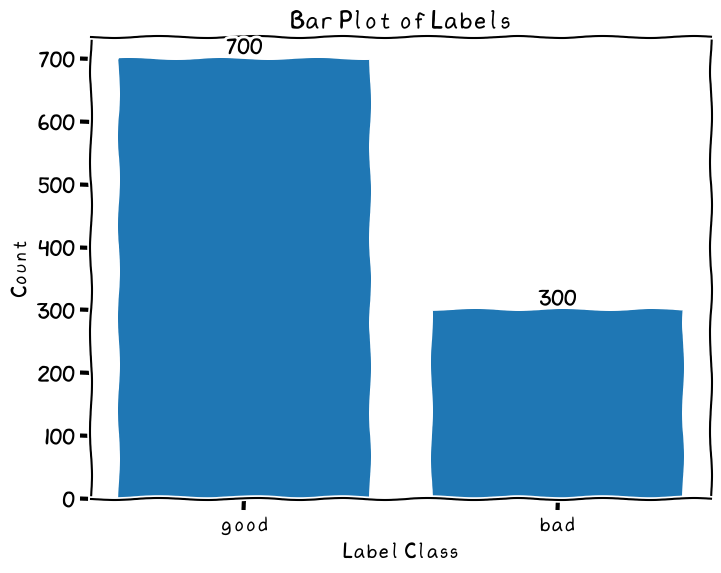

In [17]:
# plot the labels to see whether it is balance or not
plot_bar(labels)

TODO

**NB:**

- The dataset is imbalance which can make a predictive model tend to bias on the majority of the class (`good`)
- We can use one or both method here: **SMOTE** and **Cost-Sensitive Training**
    - **Synthetic Minority Oversampling TEchnique (SMOTE)**: works by creating synthetic samples from the minority class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances.
    - **Cost-Sensitive Training**: giving a higher penalty to misclassified minority classes during the training of the machine learning algorithm (using the `cost-matrix` based on the arrf dataset comment). It changes the algorithm's objective function to penalize mistakes on the minority class more heavily. This can make the model pay more attention to the minority class, but it doesn't help the model learn more about the structure of the minority class's data, like SMOTE does.

In [18]:
# we make the alternate SMOTE dataset to compare in the end
smote = SMOTE(random_state=RANDOM_SEED)
smote_features = features.copy()
for col in smote_features.select_dtypes('int').columns:
    smote_features[col] = smote_features[col].astype(float)
smote_features, smote_labels = smote.fit_resample(smote_features, labels)

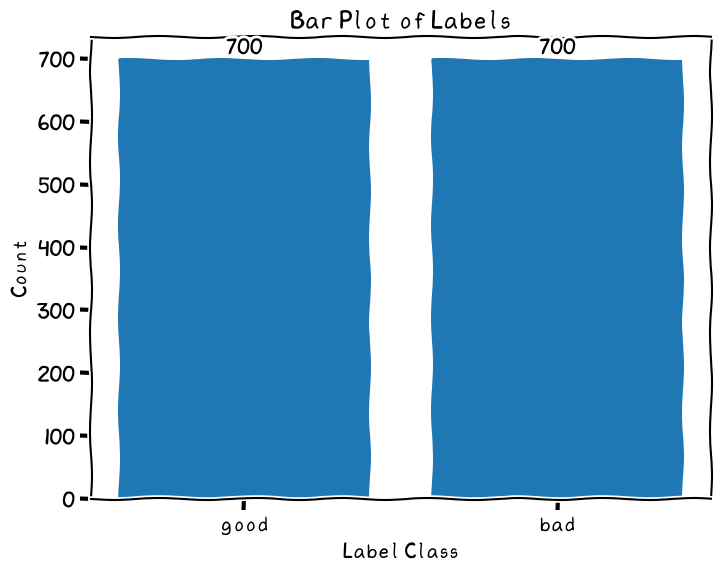

In [19]:
# plot the smote labels to see the after effect
plot_bar(smote_labels)

In [20]:
check_missing_df(smote_features)

There are no missing values in the dataframe.


In [21]:
check_missing_s(smote_labels)

There are no missing values in the series.


In [22]:
# quick comparison
display(features)
display(smote_features)

checking_status  duration  credit_history   purpose  credit_amount   
0           0.505495         6        0.828767  0.777778           1169  \
1           0.611940        48        0.682420  0.781362           5951   
2           0.882952        12        0.828767  0.551020           2096   
3           0.505495        42        0.680529  0.677778           7882   
4           0.509158        24        0.689655  0.622318           4870   
..               ...       ...             ...       ...            ...   
995         0.882952        12        0.680529  0.677778           1736   
996         0.505495        30        0.680529  0.833333           3857   
997         0.882952        12        0.680529  0.777778            804   
998         0.509158        45        0.682420  0.781362           1845   
999         0.608209        45        0.828767  0.833333           4576   

     savings_status  employment  installment_commitment  personal_status   
0          0.824176    0.746032                       4         0.733090  \
1          0.641196    0.695266                       2         0.650485   
2          0.639535    0.774566                       2         0.733090   
3          0.639535    0.774566                       2         0.733090   
4          0.641196    0.695266                       3         0.734918   
..              ...         ...                     ...              ...   
995        0.639535    0.774566                       3         0.647249   
996        0.639535    0.692308                       4         0.591837   
997        0.639535    0.746032                       4         0.733090   
998        0.641196    0.695266                       4         0.734918   
999        0.666667    0.622951                       3         0.733090   

     other_parties  residence_since  property_magnitude  age   
0         0.699779                4            0.786477   67  \
1         0.700883                2            0.790036   22   
2         0.699779                3            0.786477   49   
3         0.803922                4            0.692641   45   
4         0.700883                4            0.568627   53   
..             ...              ...                 ...  ...   
995       0.699779                4            0.786477   31   
996       0.699779                4            0.692641   40   
997       0.699779                4            0.691843   38   
998       0.700883                4            0.568627   23   
999       0.699779                4            0.691843   27   

     other_payment_plans   housing  existing_credits       job   
0               0.724477  0.738764                 2  0.704293  \
1               0.725707  0.740169                 1  0.705882   
2               0.724477  0.738764                 1  0.718593   
3               0.724477  0.588785                 1  0.704293   
4               0.725707  0.598131                 2  0.705882   
..                   ...       ...               ...       ...   
995             0.724477  0.738764                 1  0.718593   
996             0.724477  0.738764                 1  0.653061   
997             0.724477  0.738764                 1  0.704293   
998             0.725707  0.598131                 1  0.705882   
999             0.724477  0.738764                 1  0.704293   

     num_dependents  own_telephone  foreign_worker  
0                 1       0.719603        0.692308  
1                 1       0.687395        0.693347  
2                 2       0.685714        0.692308  
3                 2       0.685714        0.692308  
4                 2       0.687395        0.693347  
..              ...            ...             ...  
995               1       0.685714        0.692308  
996               1       0.719603        0.692308  
997               1       0.685714        0.692308  
998               1       0.722084        0.693347  
999               1       0.685714        0.69

checking_status   duration  credit_history   purpose  credit_amount   
0            0.505495   6.000000        0.828767  0.777778    1169.000000  \
1            0.611940  48.000000        0.682420  0.781362    5951.000000   
2            0.882952  12.000000        0.828767  0.551020    2096.000000   
3            0.505495  42.000000        0.680529  0.677778    7882.000000   
4            0.509158  24.000000        0.689655  0.622318    4870.000000   
...               ...        ...             ...       ...            ...   
1395         0.606633  34.967290        0.690153  0.773150    2668.624768   
1396         0.611940  24.218910        0.682420  0.838181   12579.602002   
1397         0.509158  19.818231        0.682420  0.733165    3169.696418   
1398         0.509440  14.991767        0.682420  0.726985    1275.054889   
1399         0.509158  21.310169        0.682420  0.781362    1833.759323   

      savings_status  employment  installment_commitment  personal_status   
0           0.824176    0.746032                4.000000         0.733090  \
1           0.641196    0.695266                2.000000         0.650485   
2           0.639535    0.774566                2.000000         0.733090   
3           0.639535    0.774566                2.000000         0.733090   
4           0.641196    0.695266                3.000000         0.734918   
...              ...         ...                     ...              ...   
1395        0.674649    0.698092                3.896729         0.654845   
1396        0.641840    0.749002                3.945273         0.652026   
1397        0.641196    0.665334                2.606077         0.650485   
1398        0.829153    0.694995                3.997256         0.650485   
1399        0.641196    0.689485                3.103390         0.659215   

      other_parties  residence_since  property_magnitude        age   
0          0.699779         4.000000            0.786477  67.000000  \
1          0.700883         2.000000            0.790036  22.000000   
2          0.699779         3.000000            0.786477  49.000000   
3          0.803922         4.000000            0.692641  45.000000   
4          0.700883         4.000000            0.568627  53.000000   
...             ...              ...                 ...        ...   
1395       0.587833         4.000000            0.575254  49.638552   
1396       0.700883         2.036485            0.568627  44.054727   
1397       0.700883         1.696961            0.761833  24.909116   
1398       0.700883         1.997256            0.694864  24.002744   
1399       0.700883         2.000000            0.780196  25.516949   

      other_payment_plans   housing  existing_credits       job   
0                0.724477  0.738764           2.00000  0.704293  \
1                0.725707  0.740169           1.00000  0.705882   
2                0.724477  0.738764           1.00000  0.718593   
3                0.724477  0.588785           1.00000  0.704293   
4                0.725707  0.598131           2.00000  0.705882   
...                   ...       ...               ...       ...   
1395             0.718917  0.598866           1.00000  0.705882   
1396             0.725707  0.598131           1.00000  0.660703   
1397             0.725707  0.740169           1.00000  0.705882   
1398             0.725707  0.612360           1.00000  0.705882   
1399             0.713609  0.740169           1.89661  0.701125   

      num_dependents  own_telephone  foreign_worker  
0           1.000000       0.719603        0.692308  
1           1.000000       0.687395        0.693347  
2           2.000000       0.685714        0.692308  
3           2.000000       0.685714        0.692308  
4           2.000000       0.687395        0.693347  
...              ...            ...             ...  
1395        1.000000       0.689186        0.693347  
1396        1.018242       0.722084        0.693347  
1397        

In [23]:
# quick comparison
display(labels)
display(smote_labels)

0      good
1       bad
2      good
3      good
4       bad
       ... 
995    good
996    good
997    good
998     bad
999    good
Name: class, Length: 1000, dtype: object

0       good
1        bad
2       good
3       good
4        bad
        ... 
1395     bad
1396     bad
1397     bad
1398     bad
1399     bad
Name: class, Length: 1400, dtype: object

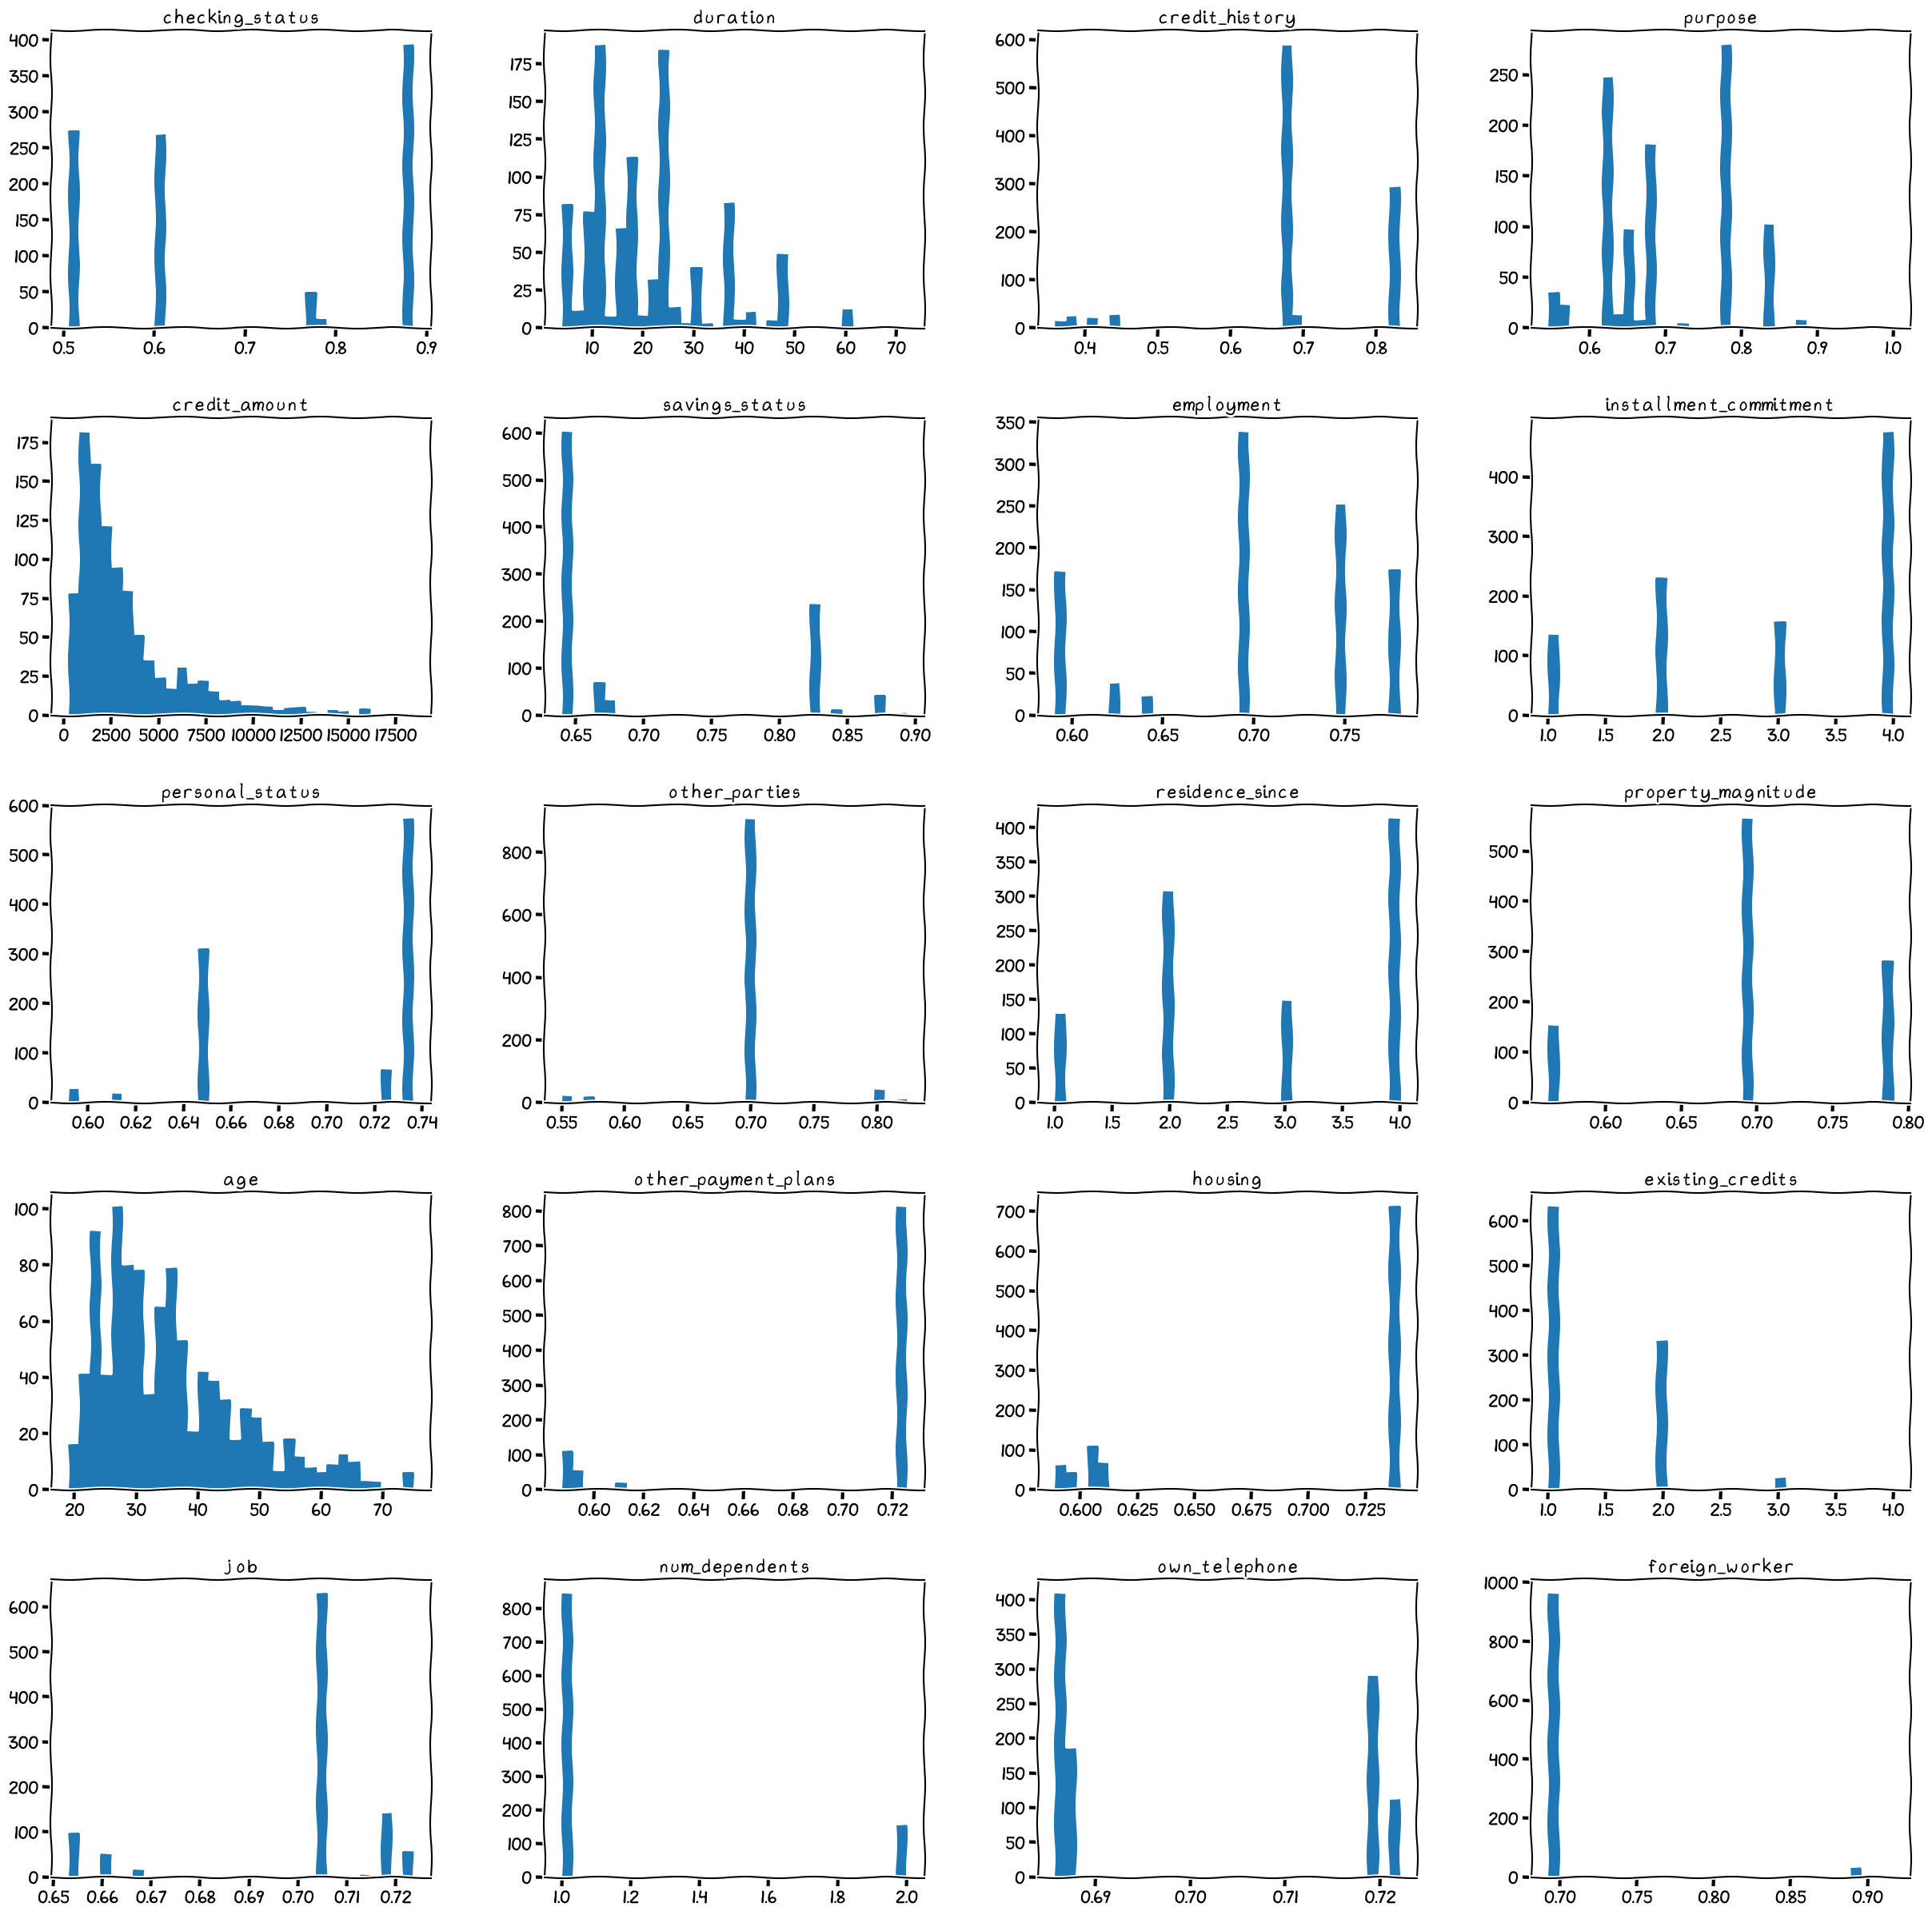

In [24]:
# take a peak at the overall histogram of all the features
hist = features.hist(figsize=(30, 30), grid=False, bins='sqrt', histtype='stepfilled')

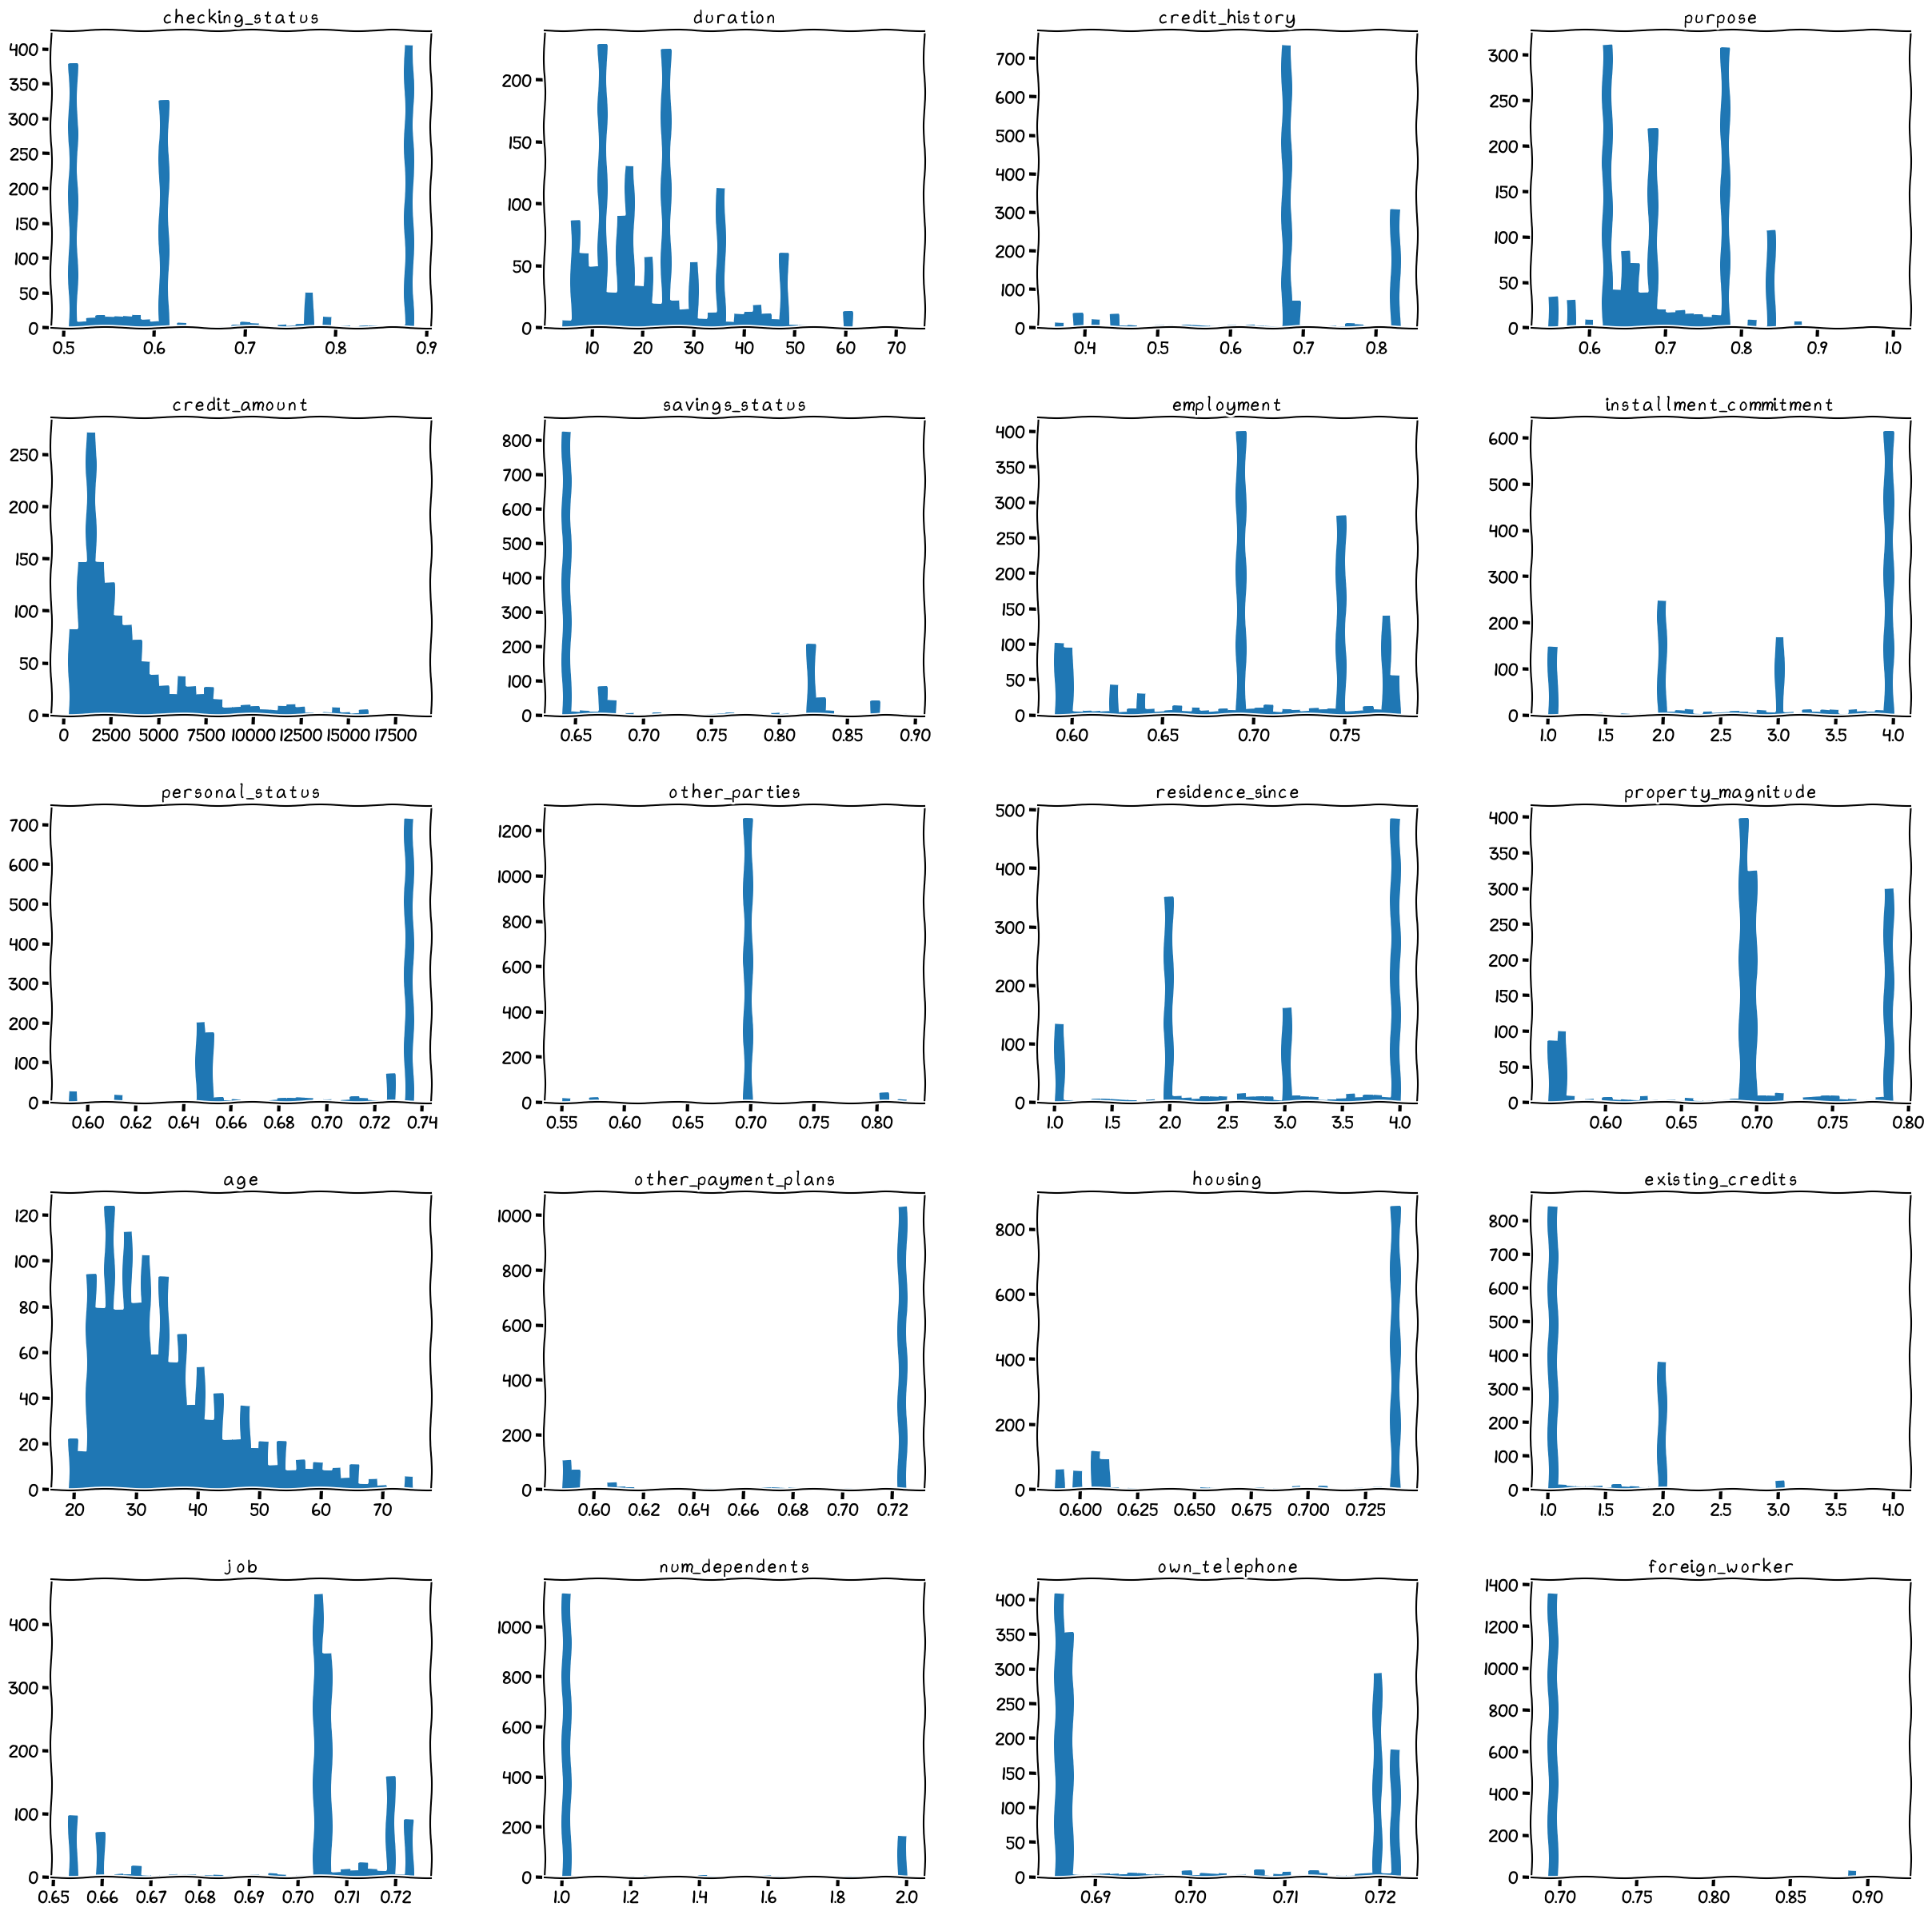

In [25]:
# take a peak at the overall histogram of all the smote features
hist = smote_features.hist(figsize=(30, 30), grid=False, bins='sqrt', histtype='stepfilled')

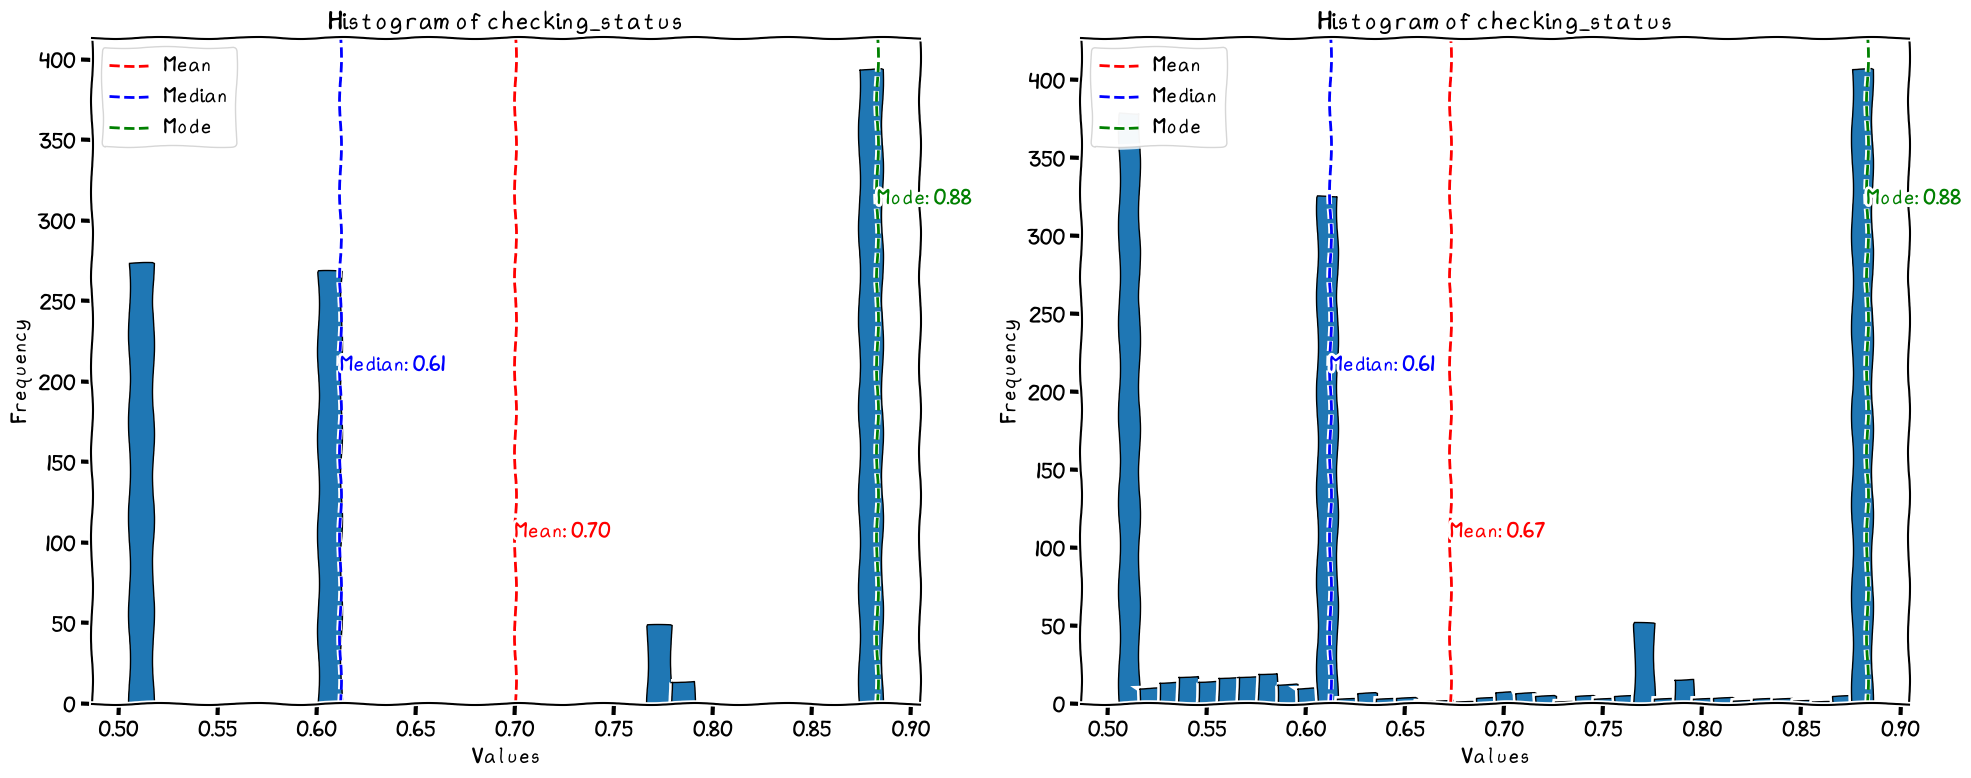

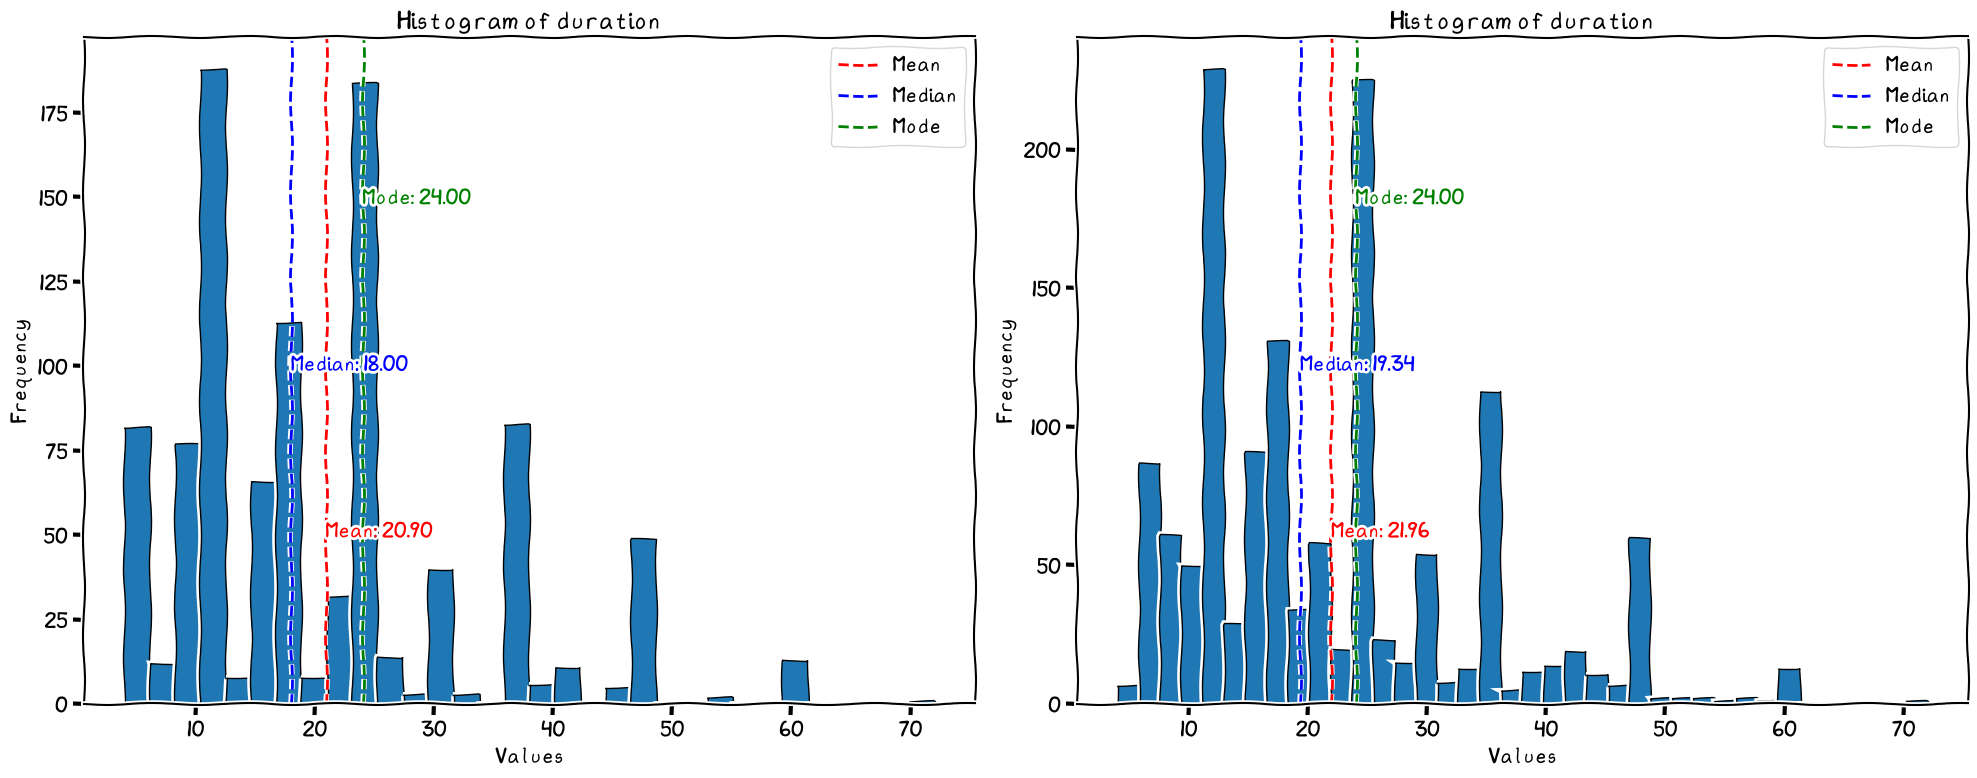

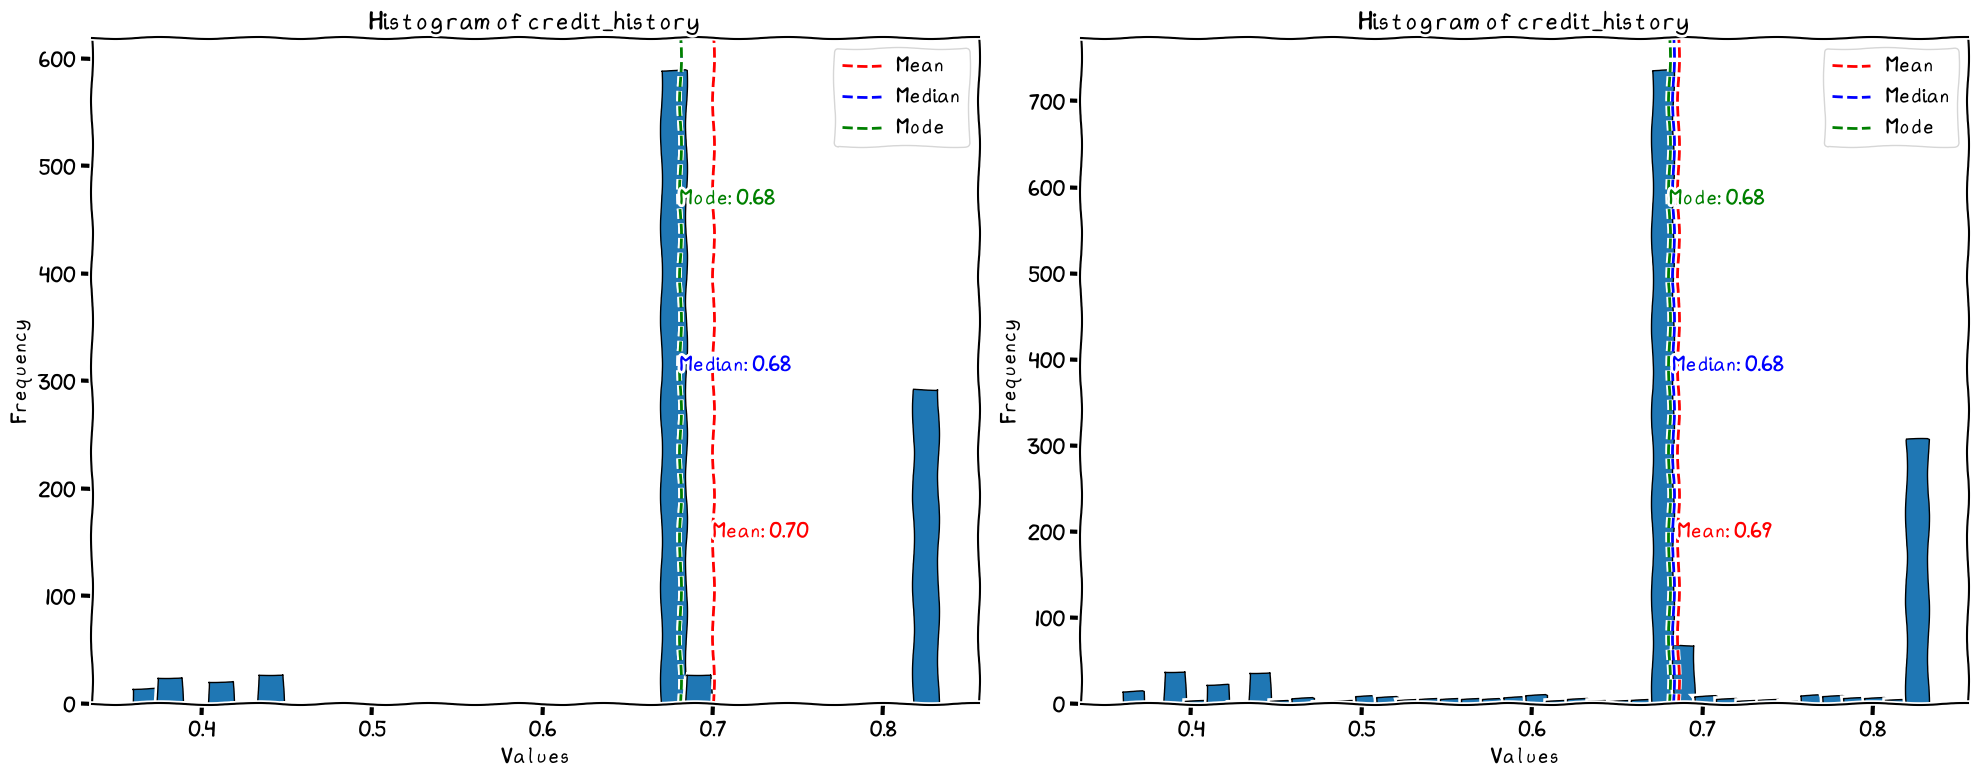

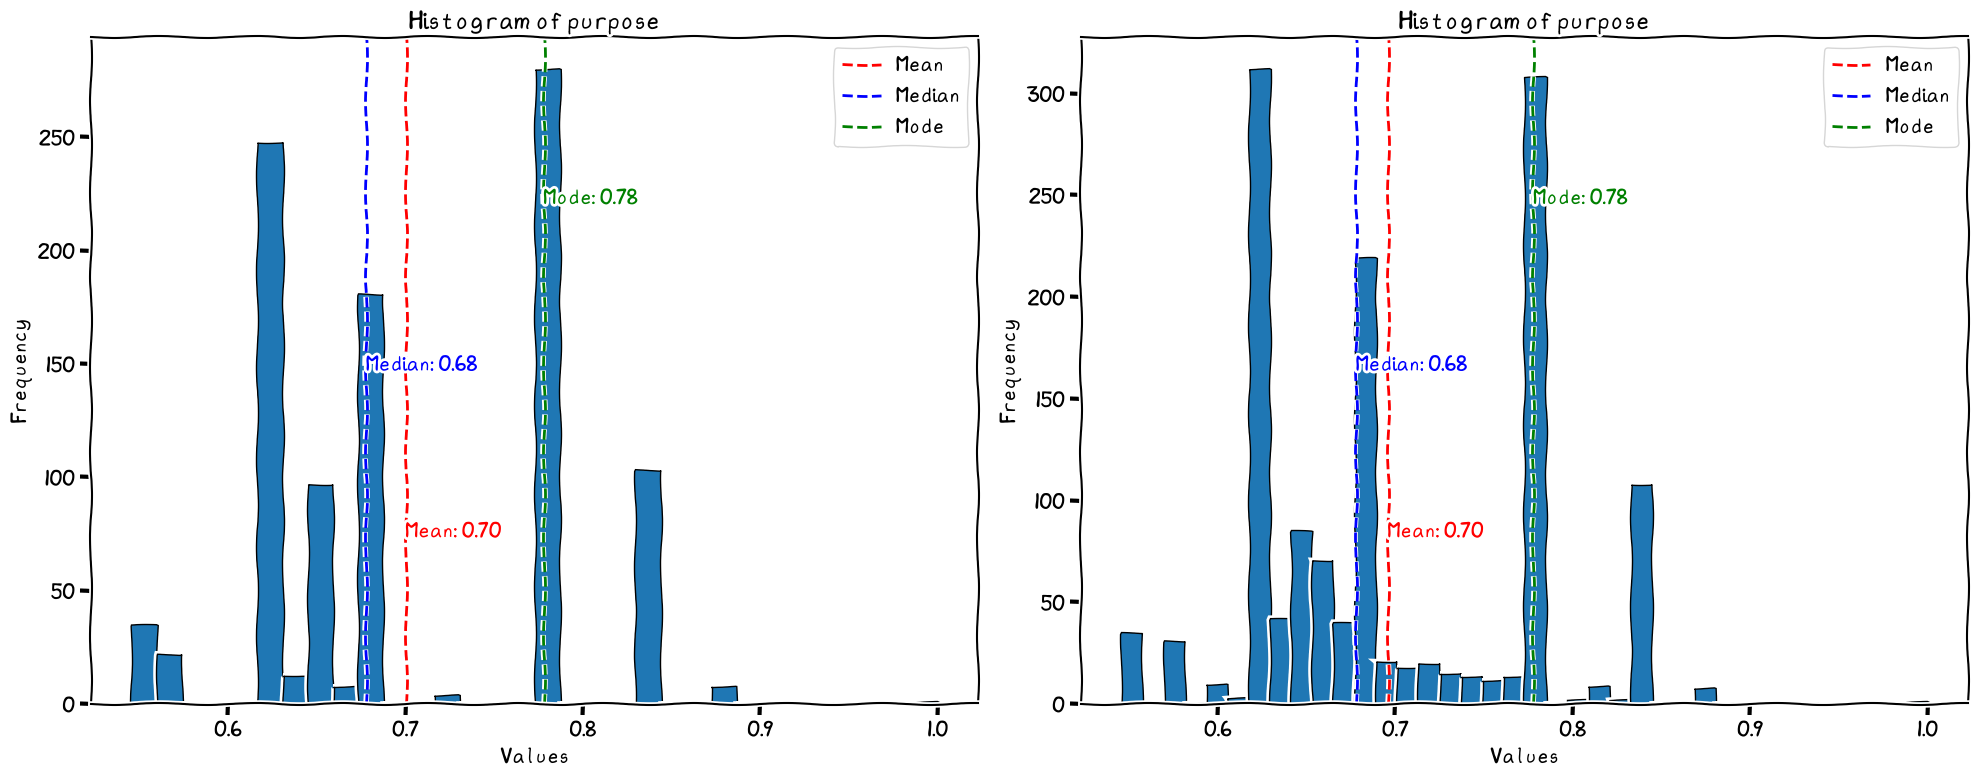

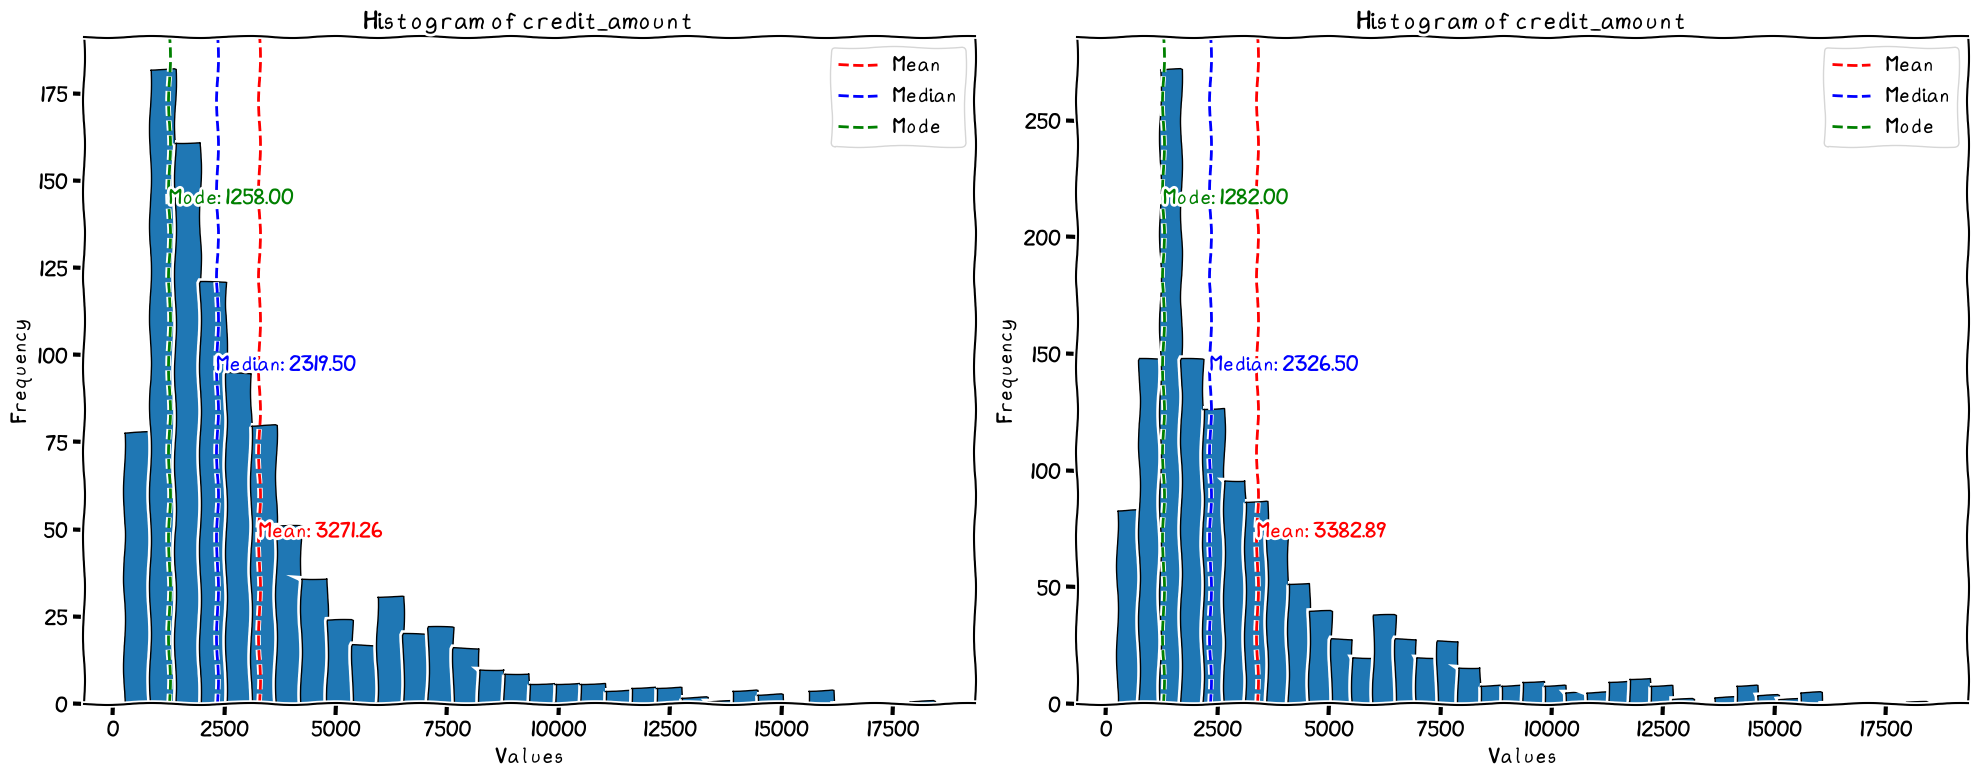

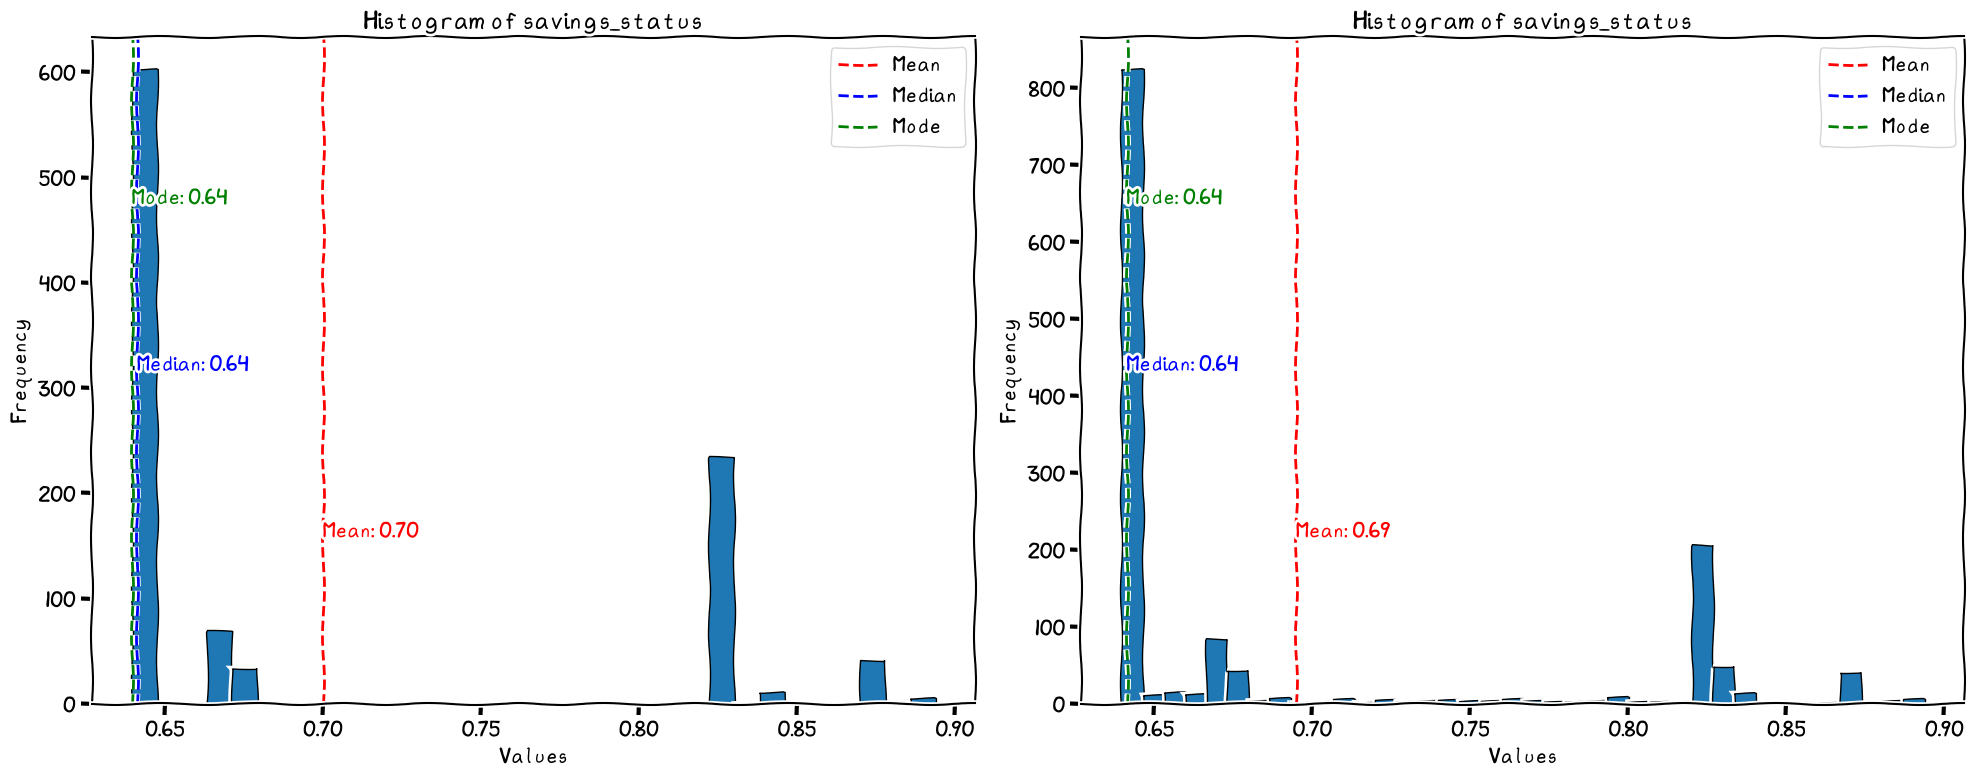

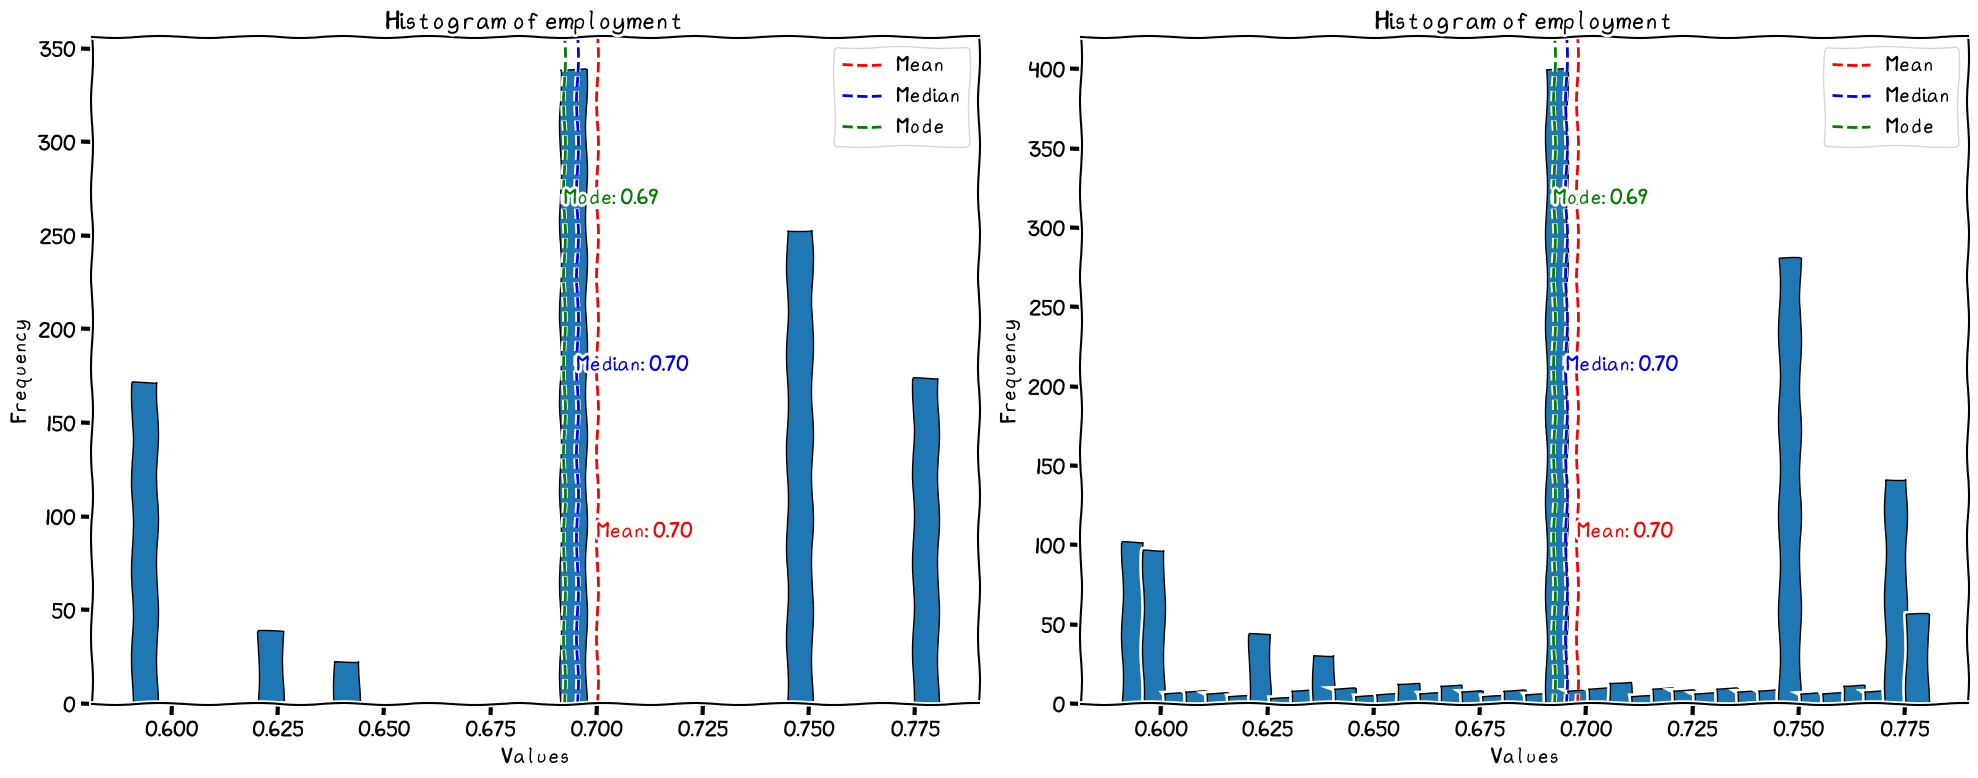

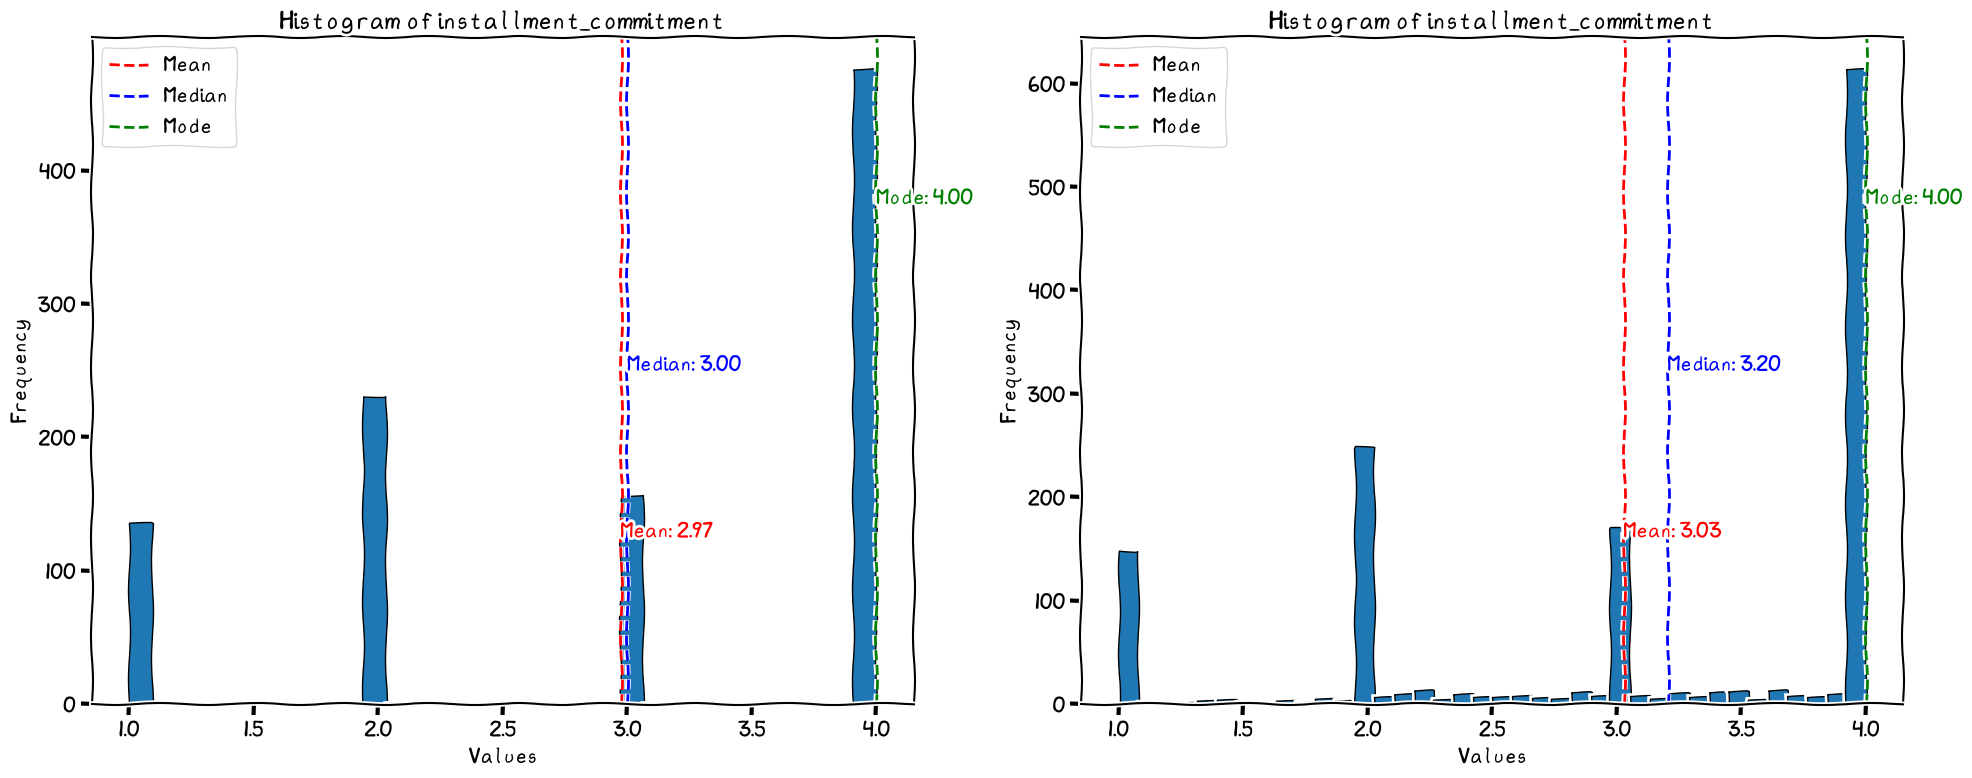

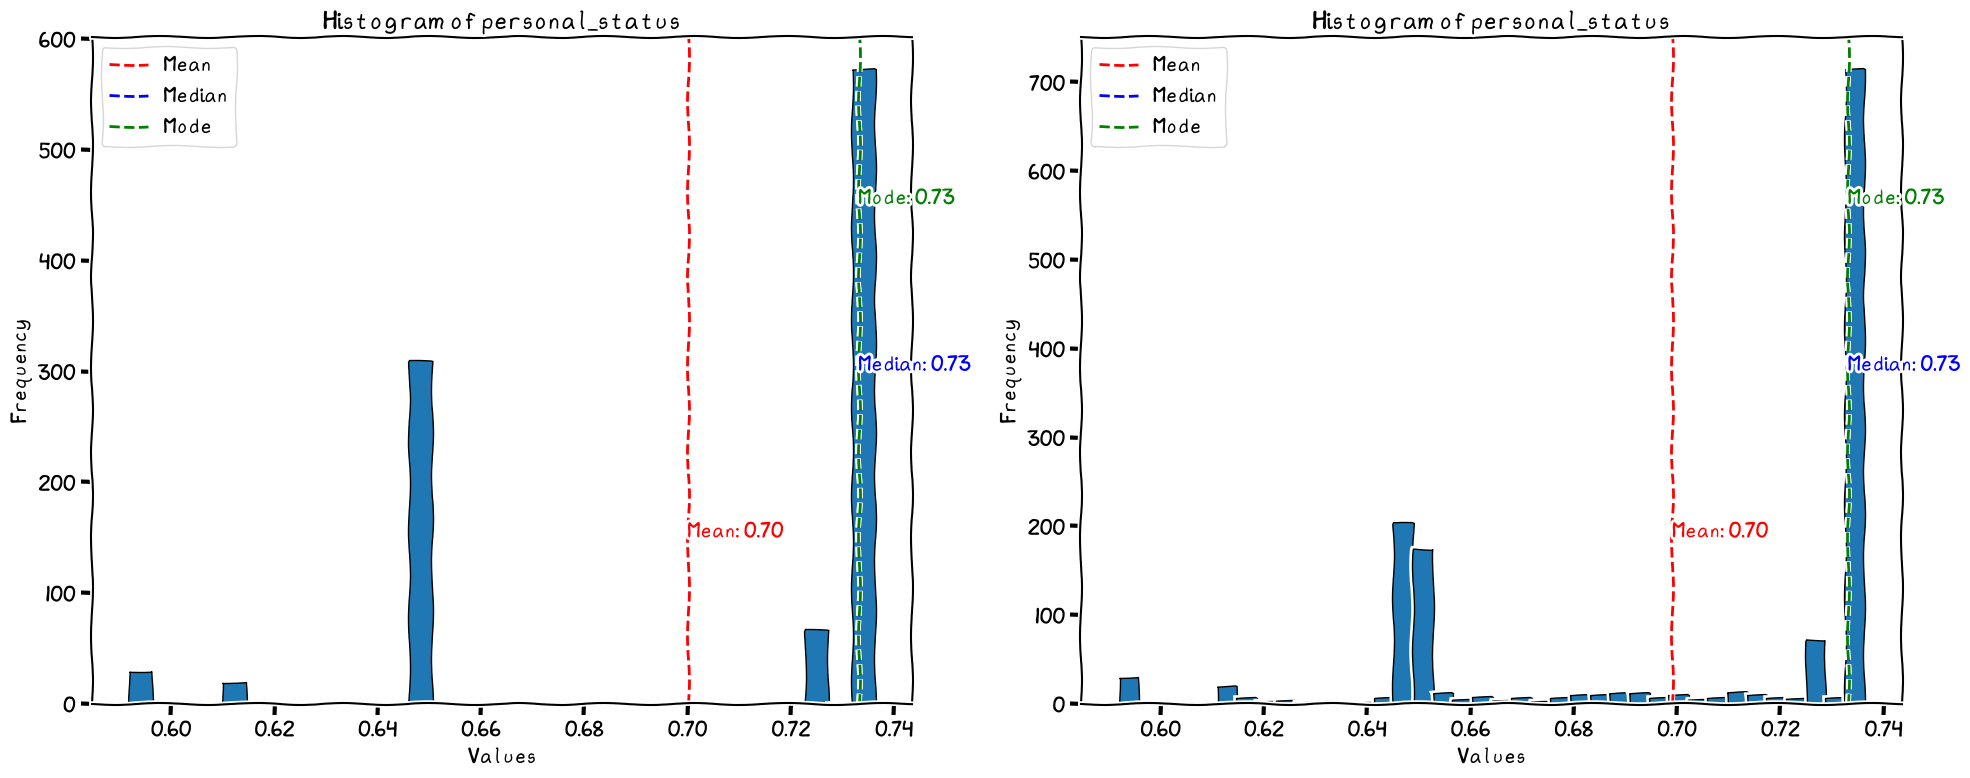

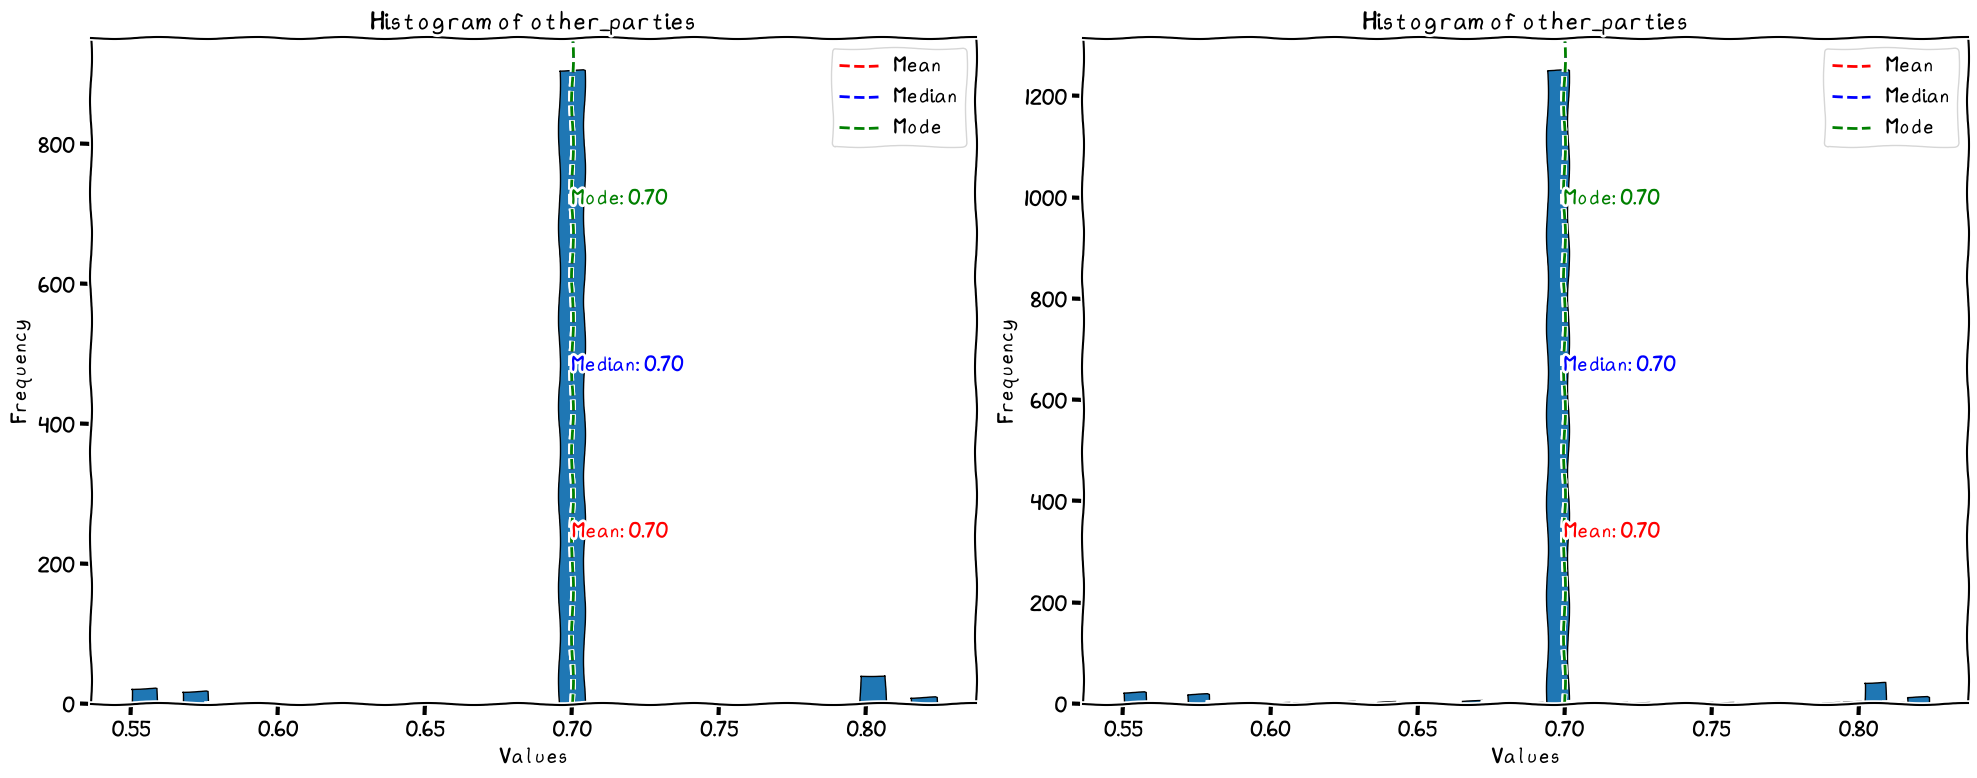

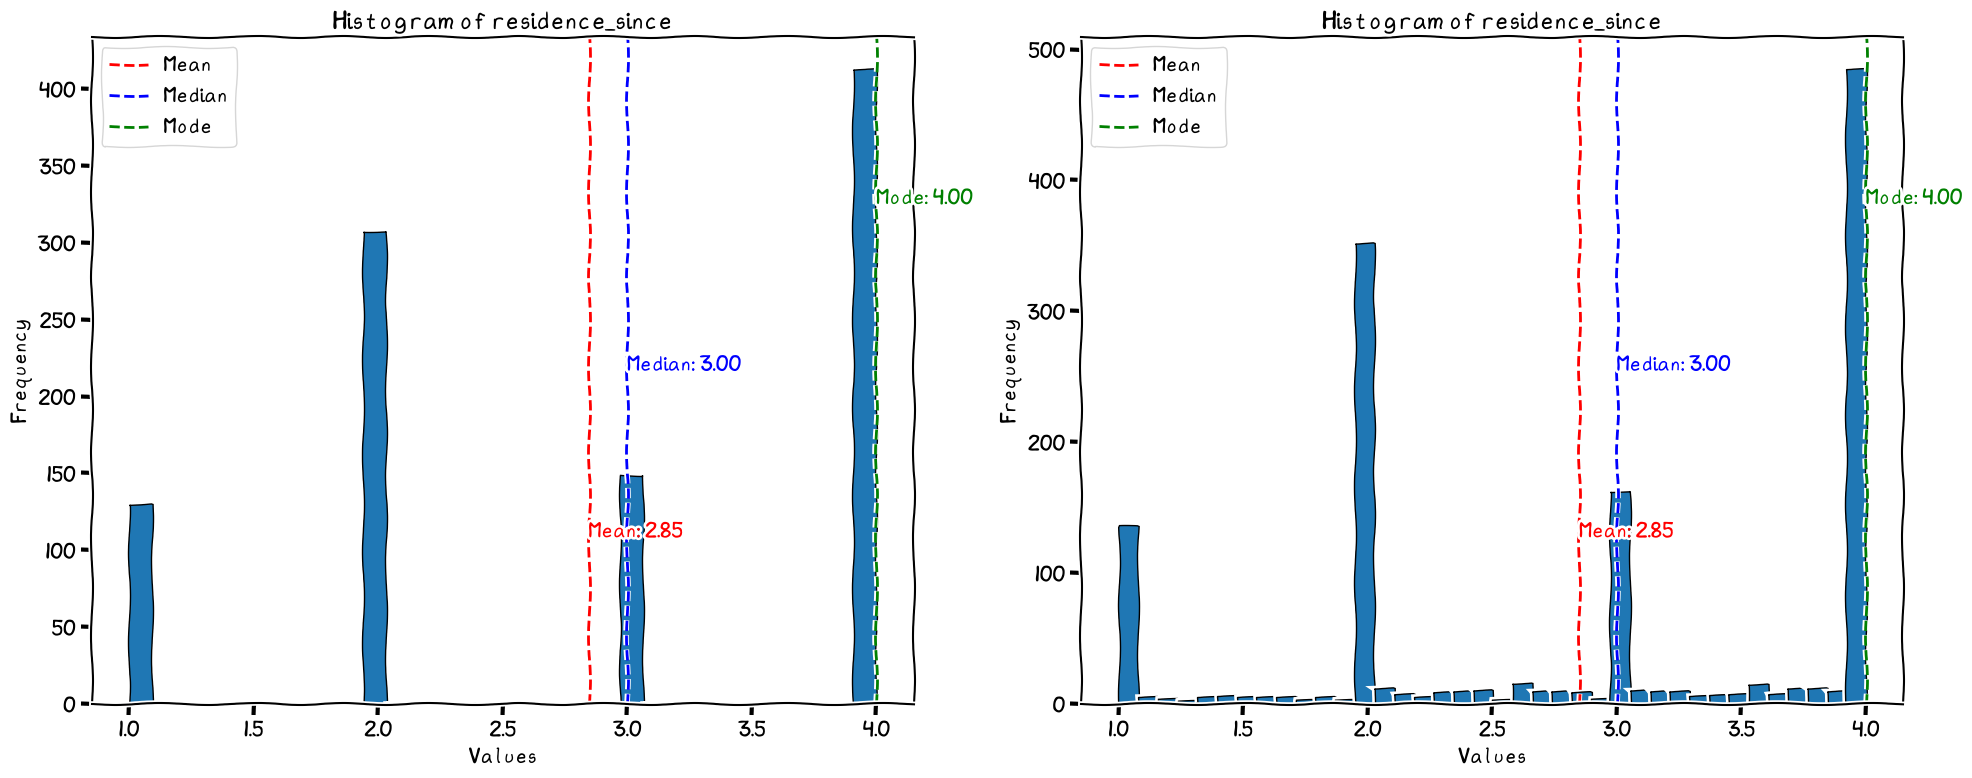

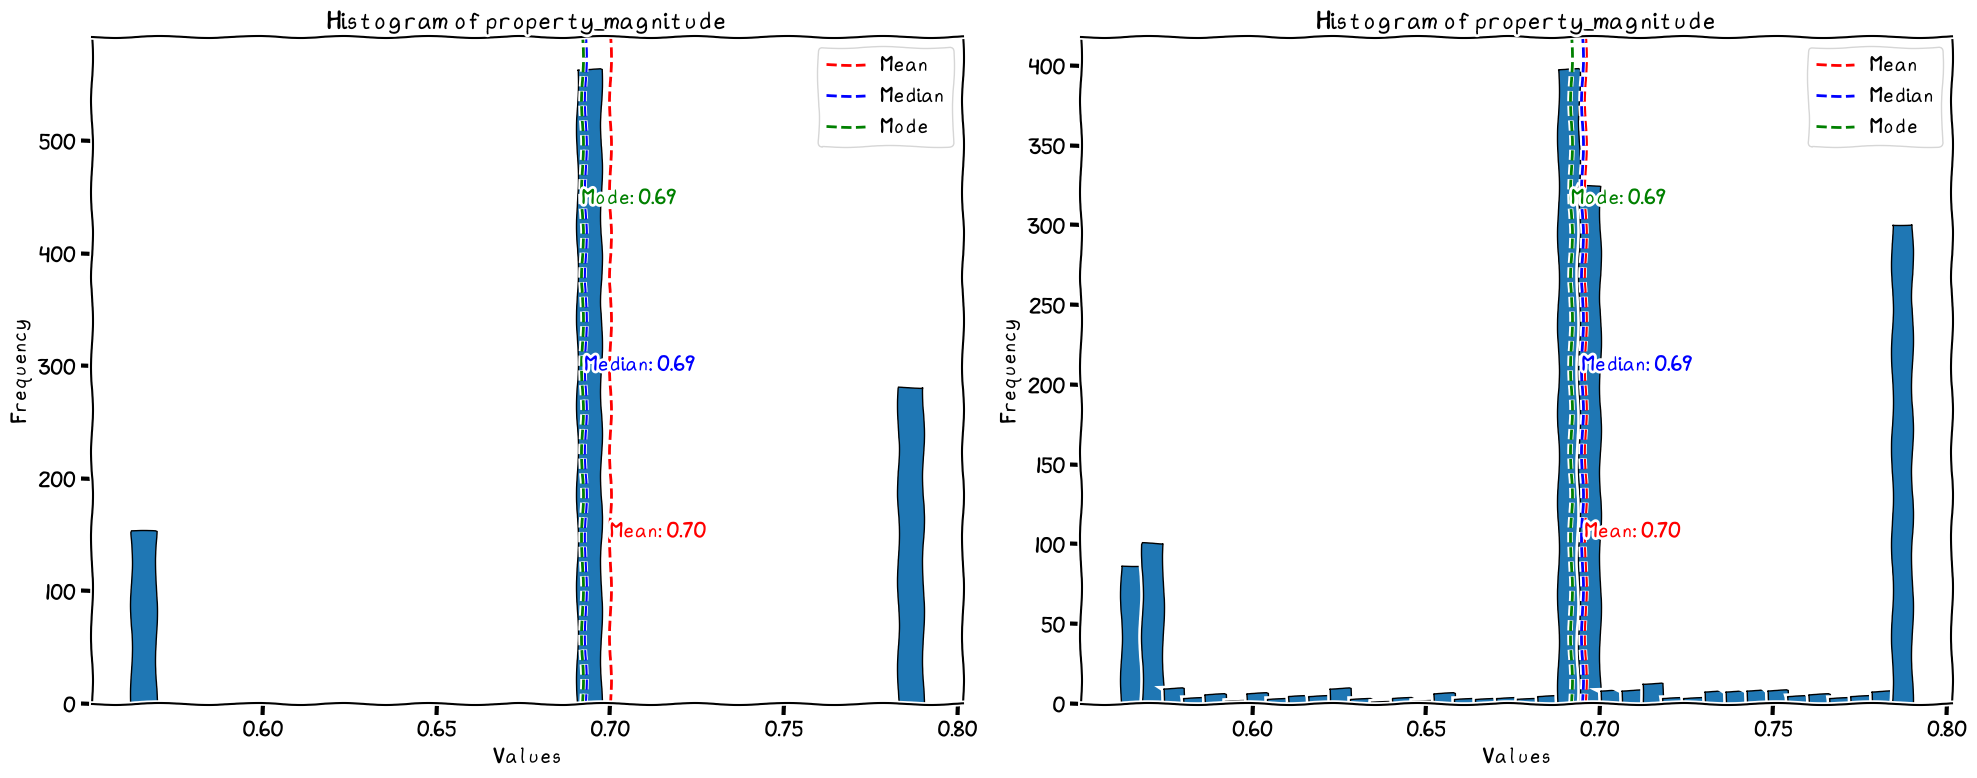

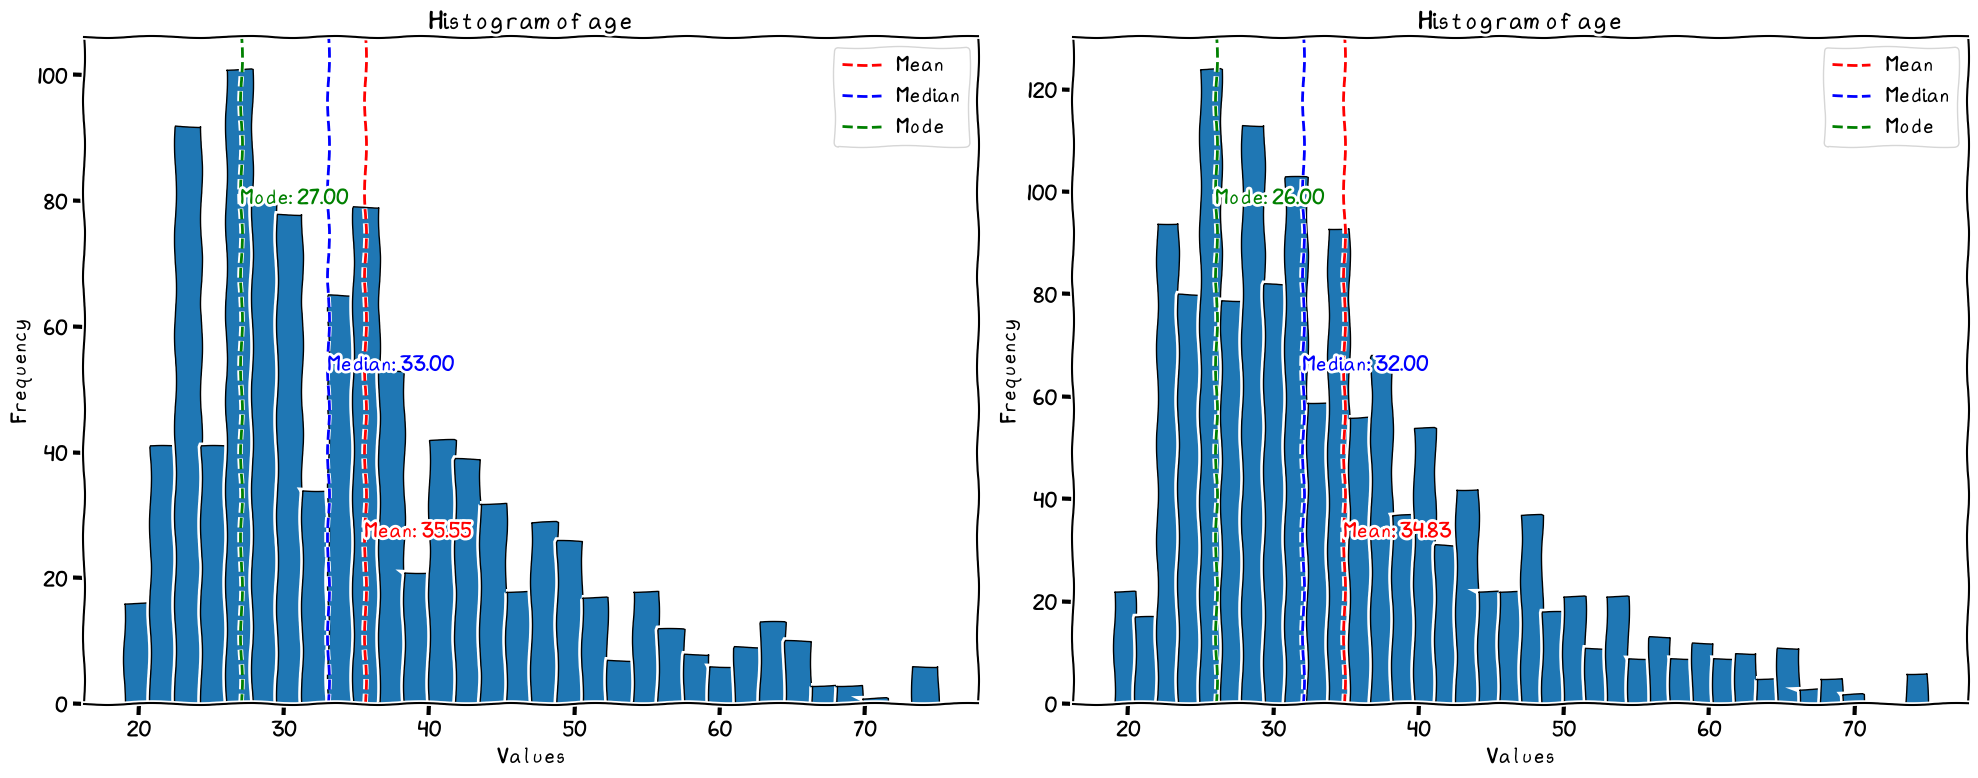

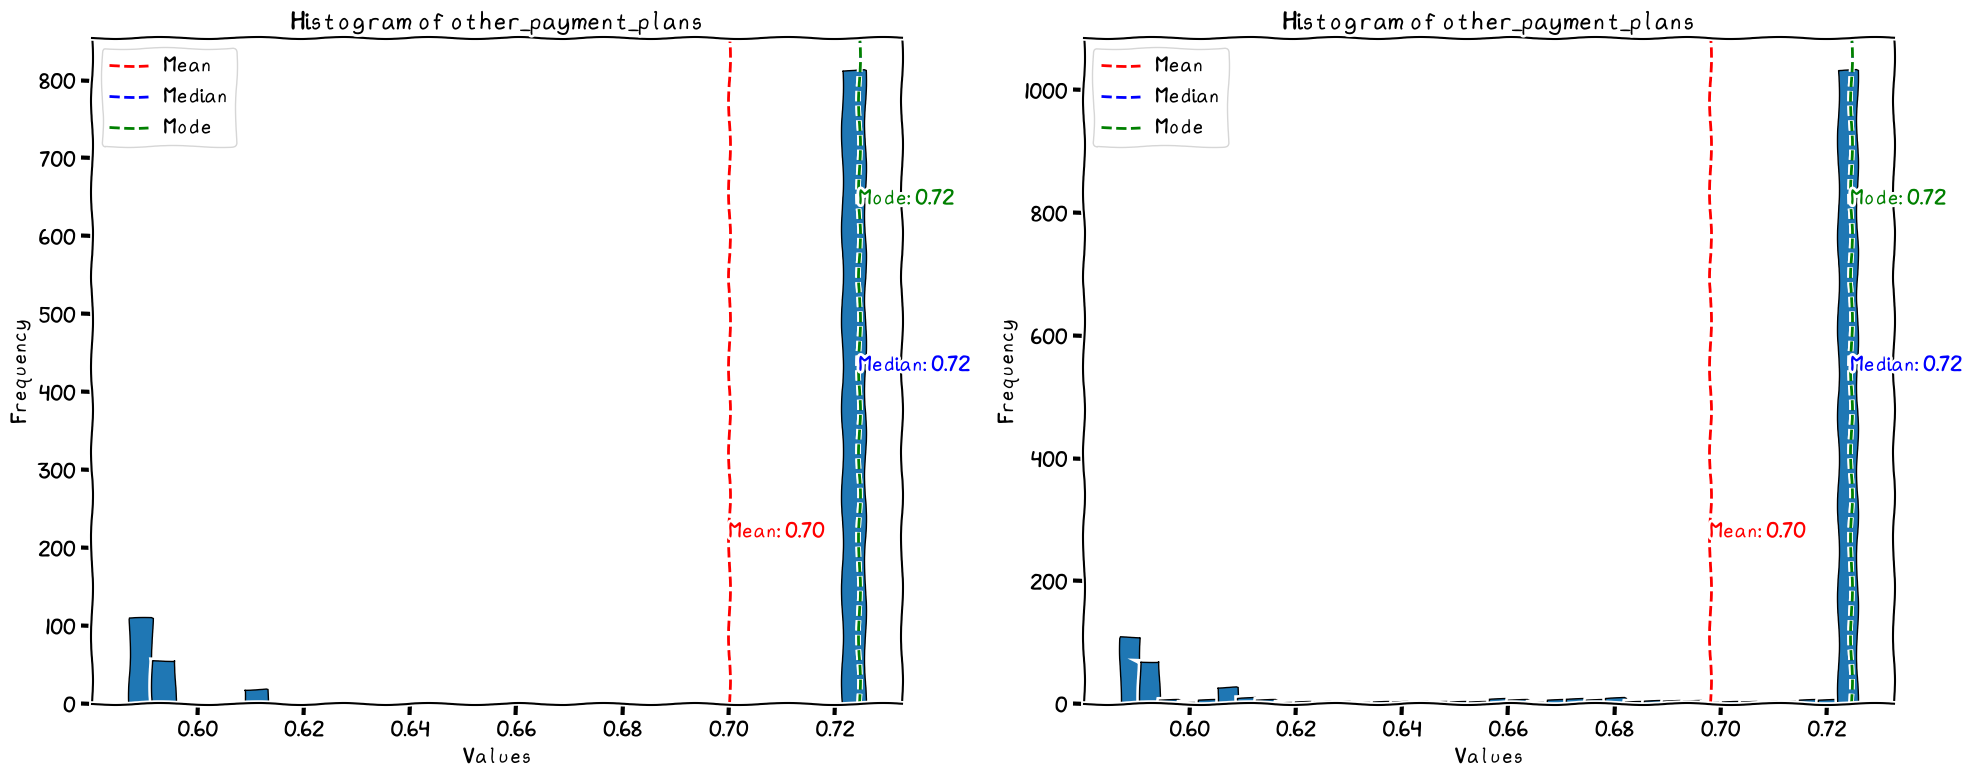

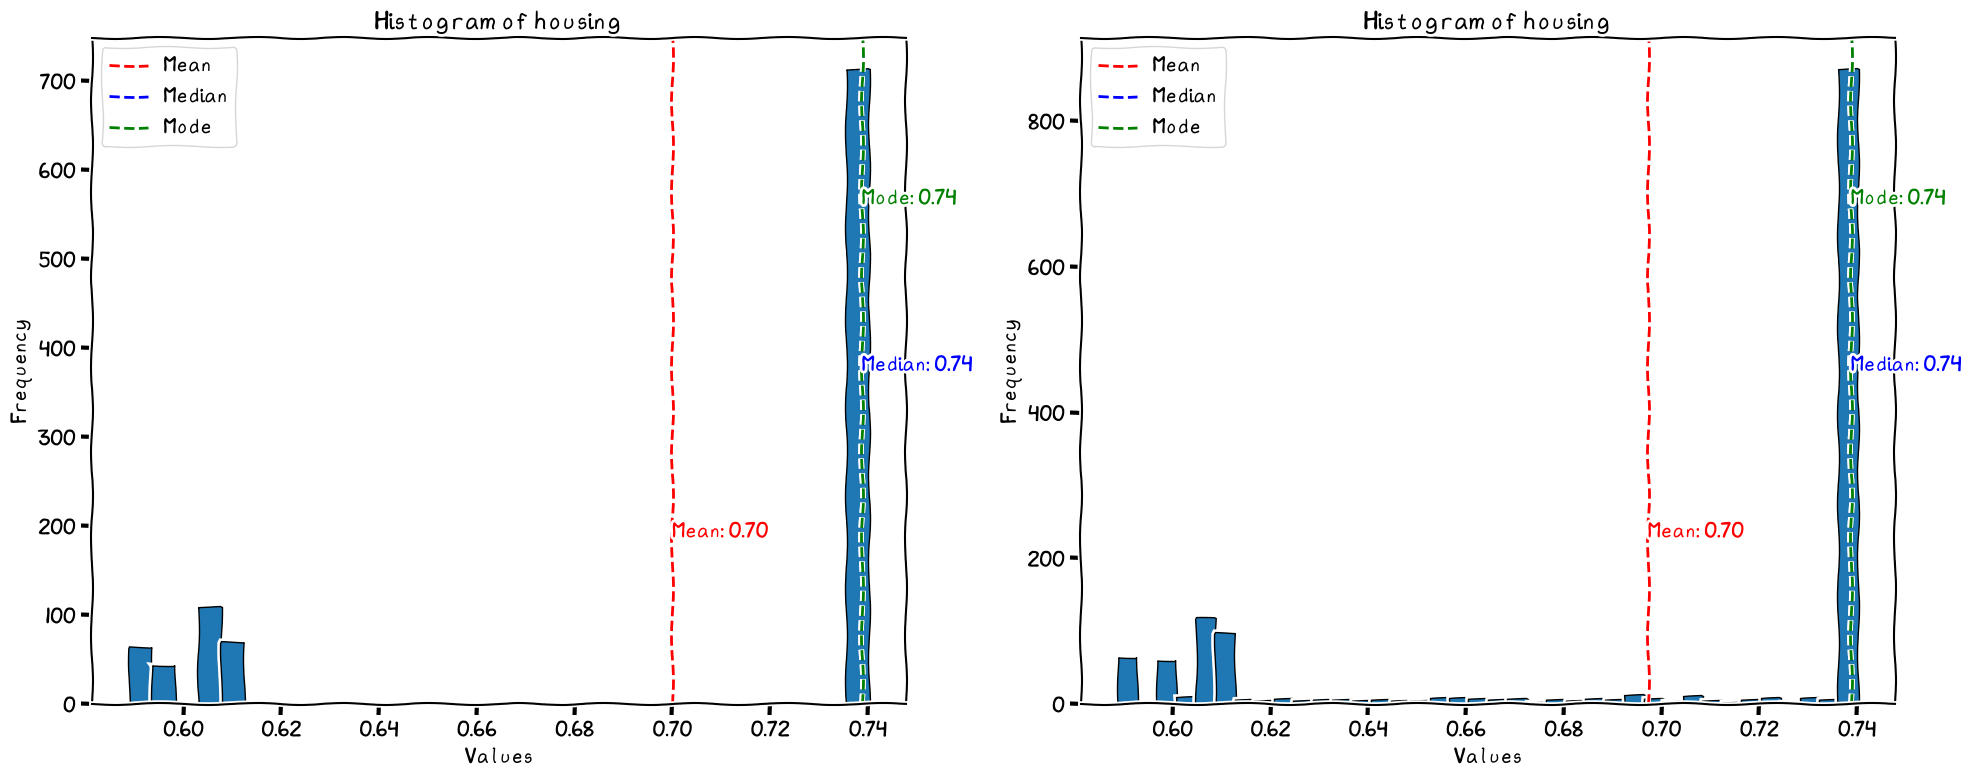

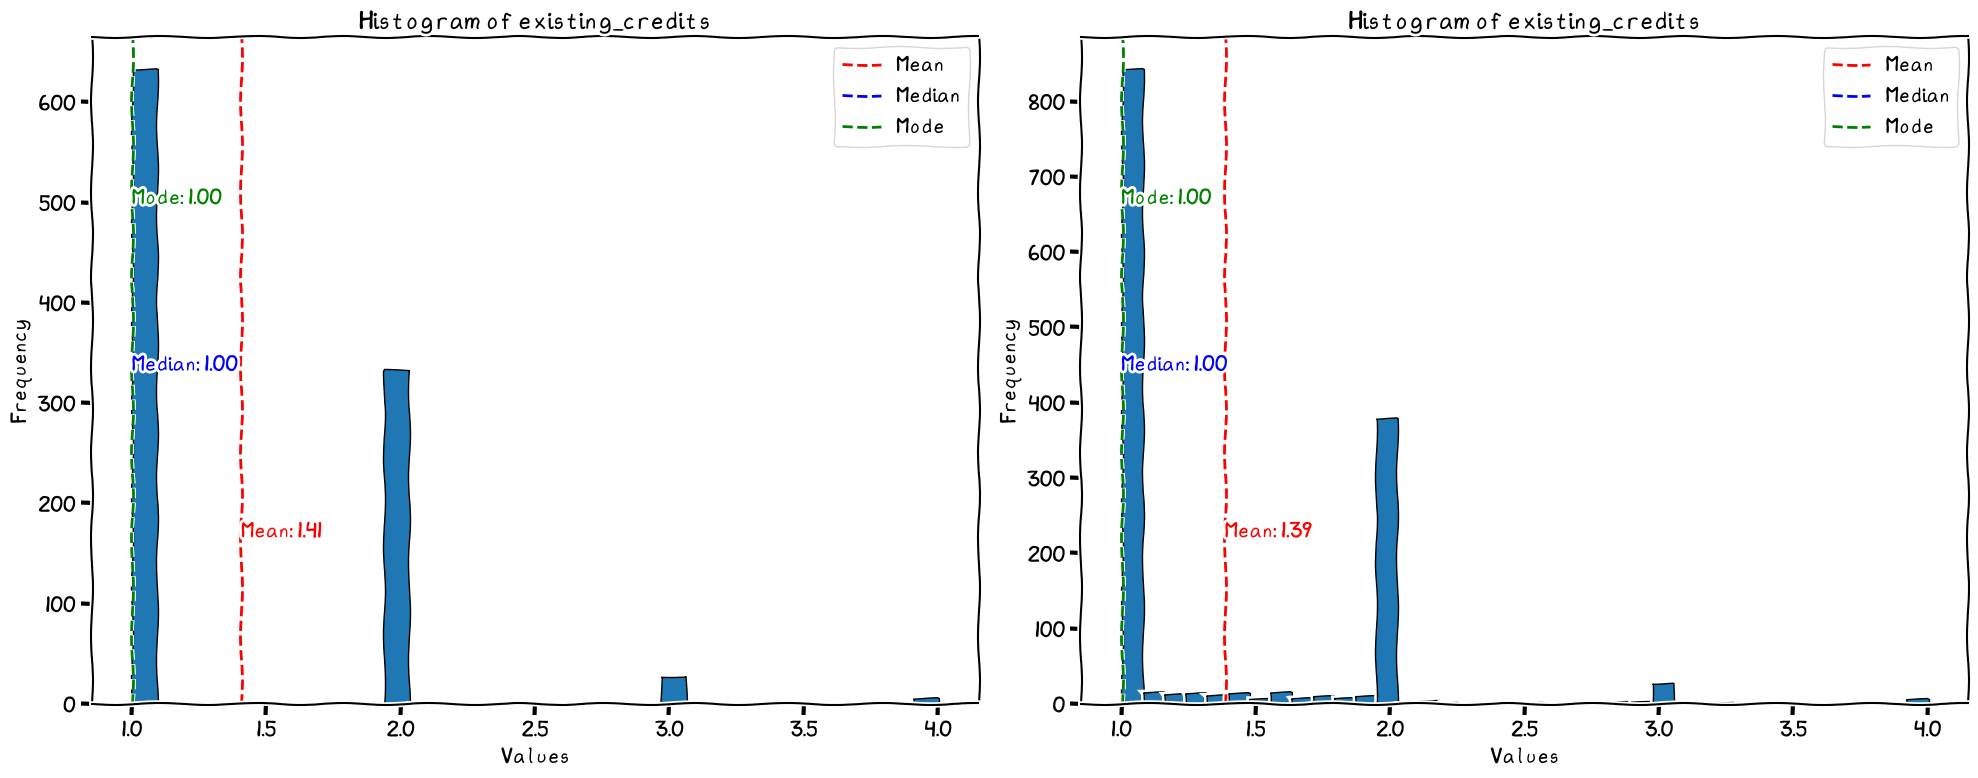

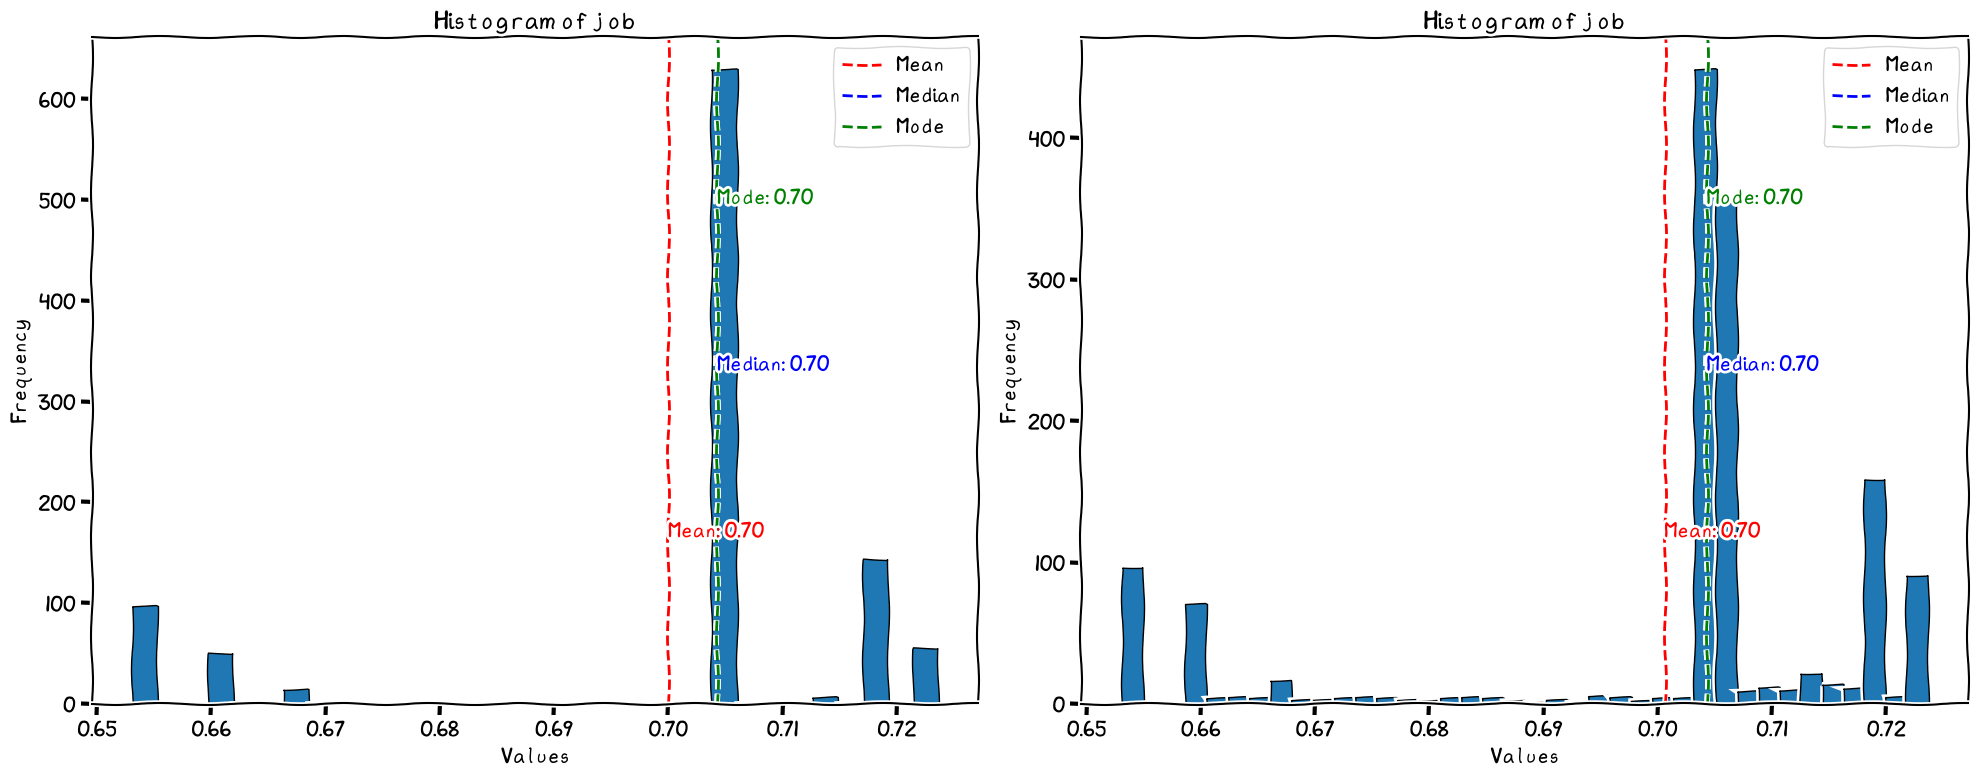

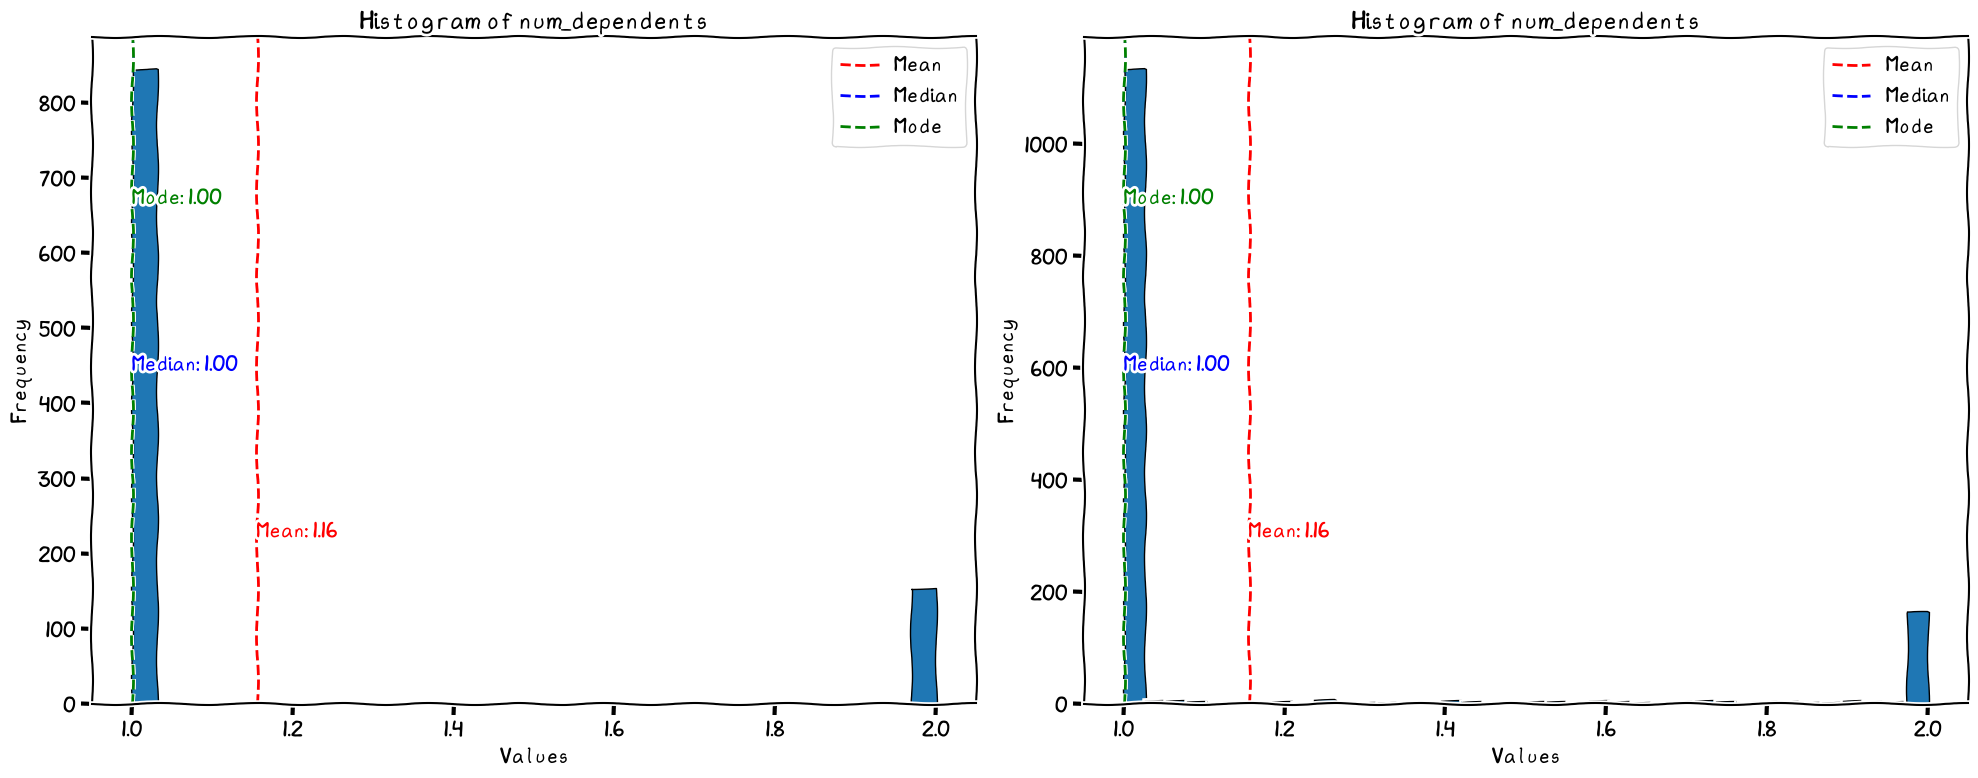

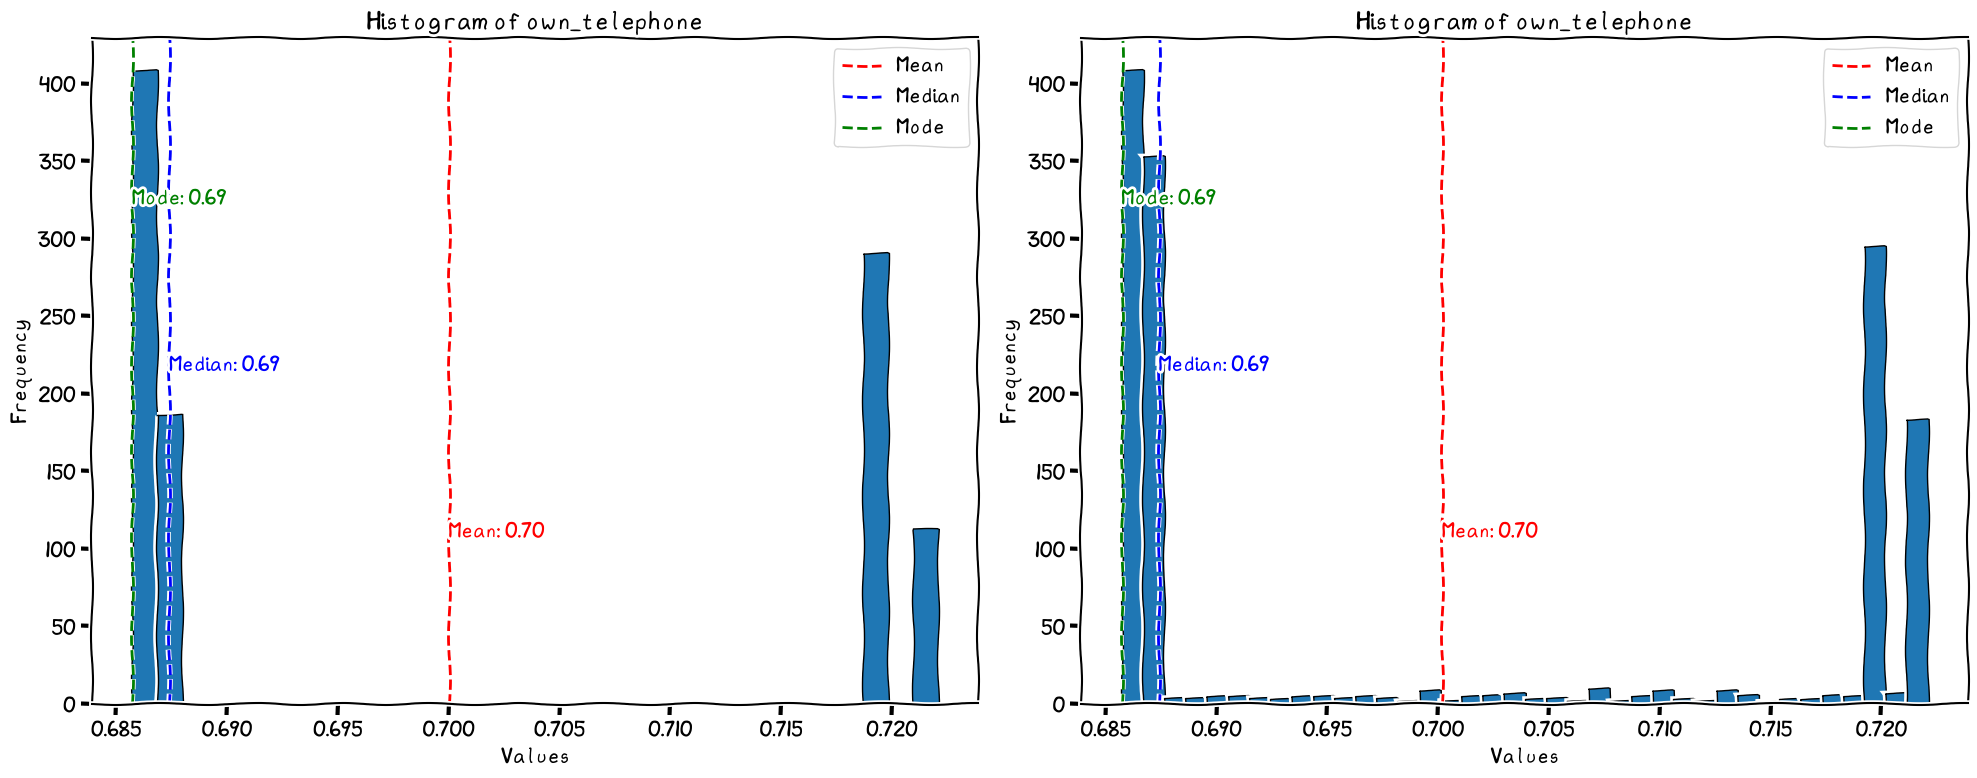

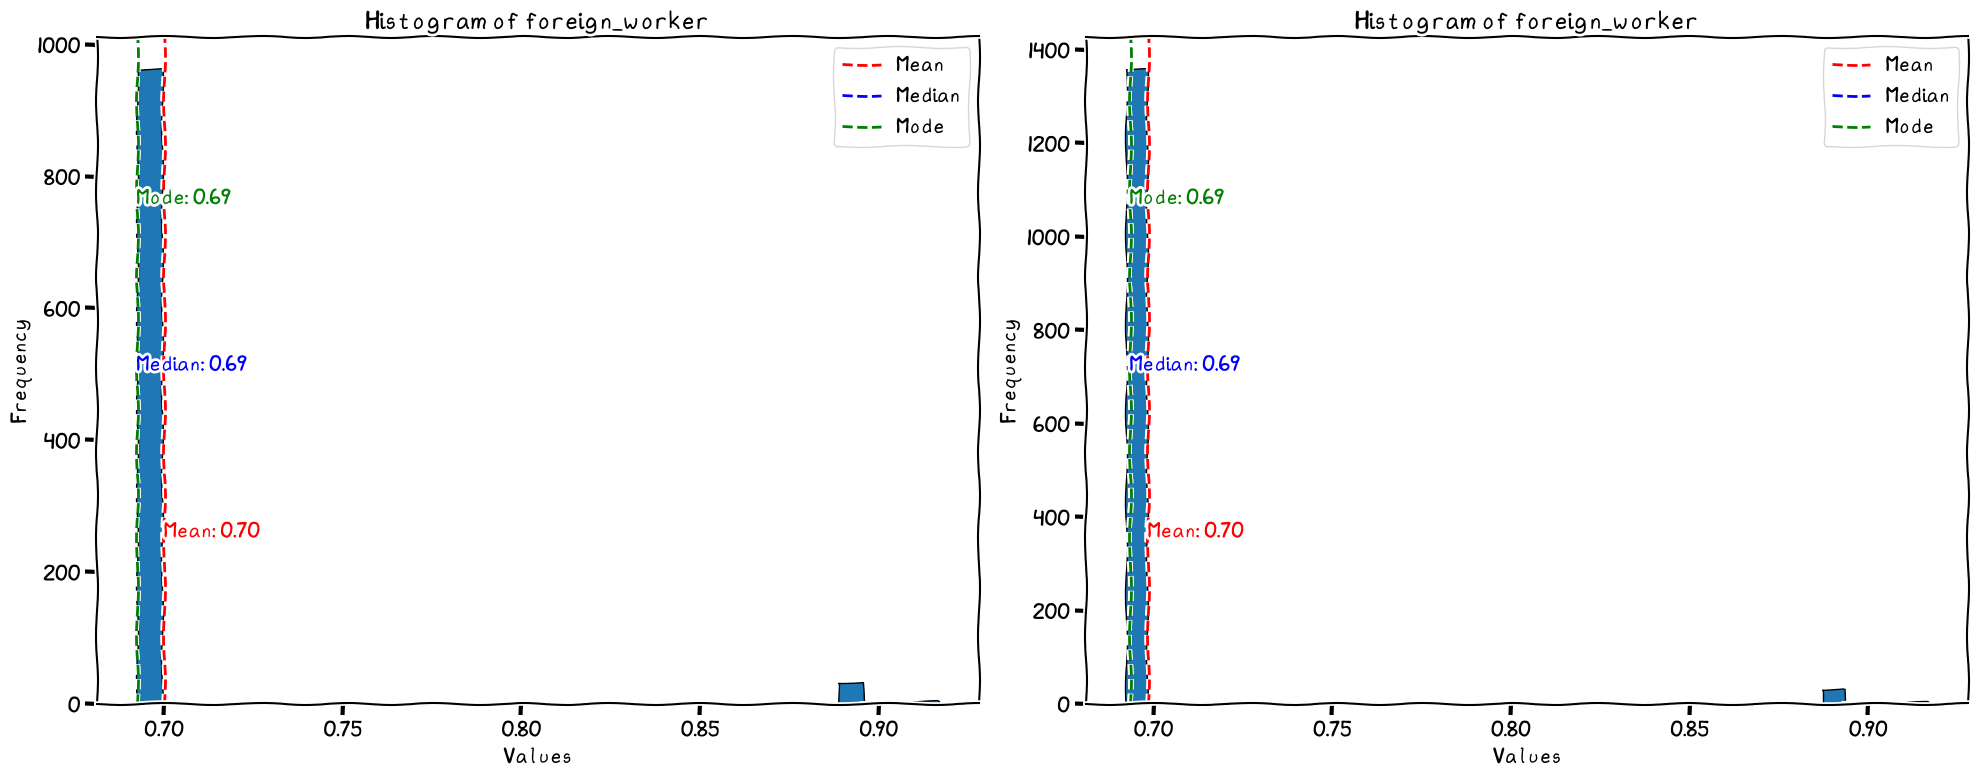

In [26]:
# compare the histogram of original and smote features
for feat, sm_fet in zip(features.columns, smote_features.columns):
    plot_histogram_comparison(features[feat], smote_features[sm_fet])

In [55]:
for feat in features.columns:
    print('skew\t', round(features[feat].skew(), 6))
    print('kurt\t', round(features[feat].kurt(), 6))
    print(features[feat].describe(), end='\n\n')

skew	 0.070584
kurt	 -1.754806
count    1000.000000
mean        0.700000
std         0.161283
min         0.505495
25%         0.509158
50%         0.611940
75%         0.882952
max         0.885496
Name: checking_status, dtype: float64

skew	 1.094184
kurt	 0.919781
count       1000.0
mean        20.903
std      12.058814
min            4.0
25%           12.0
50%           18.0
75%           24.0
max           72.0
Name: duration, dtype: Float64

skew	 -1.175146
kurt	 1.774459
count    1000.000000
mean        0.700000
std         0.113943
min         0.358974
25%         0.680529
50%         0.680529
75%         0.828767
max         0.832192
Name: credit_history, dtype: float64

skew	 0.247203
kurt	 -1.094125
count    1000.000000
mean        0.700000
std         0.084233
min         0.545455
25%         0.622318
50%         0.677778
75%         0.777778
max         1.000000
Name: purpose, dtype: float64

skew	 1.949628
kurt	 4.29259
count         1000.0
mean        3271.258
std      2

In [ ]:
# todo correlation matrix

In [ ]:
# todo another something that I probably forget and need to check the old colab to regain my memory

## Feature Engineering

## Modelling

## Evaluation 

## Future Works

1. Although we utilized the original .arrf dataset which contains both numerical and categorical data for our analysis, we have only explored feature engineering based on this version. In future works, it could be beneficial to compare the results with other versions of the dataset, such as the numerical version.

2. A notable attribute in our dataset is `personal_status`, which is a composite feature that includes both gender and marital status. In our current approach, these features are combined into a single attribute. However, it is possible that separating these features might provide different insights and potentially improve model performance. In future works, we could explore the impact of separating composite features like this into individual attributes.

3. As discussed in the [Attribute Description](#attribute-description), determining the optimal combination of features for model training is crucial. Although ordinal attributes can be derived from either nominal or ratio attributes, our focus here is on the original nominal and ratio attributes. This approach leaves room for numerous combinations of features to explore, making the quest for optimal feature selection an interesting future direction. The way we categorize data — whether it's nominal, ordinal, or ratio — can significantly impact model performance, underscoring the importance of this ongoing exploration.

4. Our current work primarily focuses on:
    - **Descriptive Statistics**: We provided summary statistics including means, medians, ranges, and standard deviations, and visualized the data.
    - **Exploratory Data Analysis (EDA)**: We generated and answered our own questions to better understand the dataset.
    - **Predictive Analysis**: We constructed a model to predict future outcomes, in this case, the potential future applicants. 

5. However, there are several important areas we have not yet addressed:
    - **Inferential Statistics**: This involves the use of statistical tests to draw conclusions about a larger population based on a sample. For example, we could use a t-test to see if the means of two groups are significantly different.
    - **Hypothesis Testing**: We haven't tested any assumptions about specific population parameters.
    - **Prescriptive Analysis**: While our predictive analysis focuses on forecasting future outcomes, prescriptive analysis suggests actions that could be taken to benefit from these predictions. This could be a valuable addition to our analysis in the future.

## References

- [Stop One-Hot Encoding Your Categorical Variables](https://medium.com/analytics-vidhya/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809)
- [Don’t use One-Hot Encoding Anymore!!!](https://medium.com/@kaoningyu/dont-use-one-hot-encoding-anymore-25b5882e533f)
- [TLDR SMOTE is Smoked](https://www.linkedin.com/feed/update/urn:li:activity:7102668506399137793)